In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# import all libraries
import numpy as np
import sklearn.model_selection
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from pathlib import Path
from io import BytesIO

from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# import games in csv
csv_path = "/content/drive/MyDrive/filtered_games_20_players.csv"

# Data loading
data = pd.read_csv(csv_path) # loading into dataframe



/tmp/ipython-input-49395873.py:30: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_path) # loading into dataframe


In [53]:
print(len(data))

NEW_LIST_OF_PLAYERS_MANUAL = [
    'ArasanX','MassterofMayhem','JelenaZ','lestri','doreality','therealYardbird',
    'Chesssknock','No_signs_of_V','Recobachess','drawingchest','kasparik_garik',
    'ChainsOfFantasia','Consent_to_treatment','Alexandr_KhleBovich','unknown-maestro_2450',
    'gefuehlter_FM','gmmitkov','positionaloldman',"Carlsen, Magnus","Nakamura, Hikaru"
]



# Create a boolean mask for rows where white or black is in the manual list
mask = data["black_name"].isin(NEW_LIST_OF_PLAYERS_MANUAL) | data["black_name"].isin(NEW_LIST_OF_PLAYERS_MANUAL)
print(mask)

# Count the number of matching samples
num_samples = mask.sum()

print(f"Number of samples with any player from manual list (white or black): {num_samples}")

print(data[['white_name', 'black_name']])

372192
0         False
1         False
2         False
3         False
4         False
          ...  
372187     True
372188     True
372189     True
372190     True
372191     True
Name: black_name, Length: 372192, dtype: bool
Number of samples with any player from manual list (white or black): 190114
                     white_name          black_name
0              Nakamura, Hikaru   Kononenko, Dmitry
1              Nakamura, Hikaru       Nureev, Garun
2              Nakamura, Hikaru       Nureev, Garun
3              Nakamura, Hikaru   Kononenko, Dmitry
4              Nakamura, Hikaru  Hammer, Jon Ludvig
...                         ...                 ...
372187             Iljin, Artem    Nakamura, Hikaru
372188             Hebert, Jean    Nakamura, Hikaru
372189            Meyer, Eugene    Nakamura, Hikaru
372190            Kleinman, Jay    Nakamura, Hikaru
372191  Kriventsov, Stanislav G    Nakamura, Hikaru

[372192 rows x 2 columns]


In [54]:
###TEST

#Added first move indicating to predict either white or black
#White = 0
#Black = 1


# --- SETTINGS ---
NEW_LIST_OF_PLAYERS_MANUAL = [
    'ArasanX','MassterofMayhem','JelenaZ','lestri','doreality','therealYardbird',
    'Chesssknock','No_signs_of_V','Recobachess','drawingchest','kasparik_garik',
    'ChainsOfFantasia','Consent_to_treatment','Alexandr_KhleBovich','unknown-maestro_2450',
    'gefuehlter_FM','gmmitkov','positionaloldman',"Carlsen, Magnus","Nakamura, Hikaru"
]

BATCH_SIZE = 32
GAME_LENGTH = 100
LEARNING_RATE = 2e-3
EPOCHS = 50

# --- DATA PREPARATION ---
TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
MANUAL_SEED = 123  # not used for now


# --- ENSURE STRINGS ---
data["white_name"] = data["white_name"].astype(str)
data["black_name"] = data["black_name"].astype(str)

# --- PLAYER MATCH FUNCTION ---
def player_match(name: str):
    lowered = name.lower()
    for player in NEW_LIST_OF_PLAYERS_MANUAL:
        if player.lower() == lowered:
            return player
    return None

# --- CREATE WHITE AND BLACK LABELS ---
data["WhiteLabel"] = data["white_name"].apply(player_match)
data["BlackLabel"] = data["black_name"].apply(player_match)

# Keep games where at least one player is in the manual list
mask = data["WhiteLabel"].notna() | data["BlackLabel"].notna()
data = data[mask].reset_index(drop=True)

# --- MAP PLAYERS TO INTEGER LABELS ---
encodep = dict(zip(NEW_LIST_OF_PLAYERS_MANUAL, range(len(NEW_LIST_OF_PLAYERS_MANUAL))))
decodep = {v: k for k, v in encodep.items()}

data["WhiteLabelID"] = data["WhiteLabel"].map(encodep)
data["BlackLabelID"] = data["BlackLabel"].map(encodep)


print("len of dataset")
print(len(data))


# --- TOKENIZATION ---
cleaner = str.maketrans({"[": "", "]": "", "'": "", ",": ""})
all_step = [k for s in data["list_of_moves"] for k in s.translate(cleaner).split()]
frequency = Counter(all_step)
dir = {"<PAD>": 2, "<UNK>": 3}

side_tokens = {"white": 0, "black": 1}
dir.update(side_tokens)
dir.update({move: len(dir) + i for i, move in enumerate(frequency)})

print(dir)

# --- STEP ENCODING WITH SIDE TOKEN ---
def step_encode(step, side_token=None):
    cleaned = step.translate(cleaner)
    tokening = cleaned.split()
    vector = list(map(lambda i_token: dir.get(i_token, 1), tokening[:GAME_LENGTH]))

    # prepend side token if provided
    if side_token is not None:
        vector = [side_token] + vector

    pad_length = GAME_LENGTH + (1 if side_token is not None else 0) - len(vector)
    vector = vector + [2] * pad_length
    return vector


class GameSequence(Dataset):
    def __init__(self, df):
        self.samples = []
        self.moves = df["list_of_moves"].to_list()
        self.white_labels = df["WhiteLabelID"].to_list()
        self.black_labels = df["BlackLabelID"].to_list()

        for i in range(len(df)):
            # only add sample if label exists
            if not pd.isna(self.white_labels[i]):
                self.samples.append((self.moves[i], 0, int(self.white_labels[i])))  # white sample
            if not pd.isna(self.black_labels[i]):
                self.samples.append((self.moves[i], 1, int(self.black_labels[i])))  # black sample

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        moves, side_token, label = self.samples[idx]
        x = torch.tensor(step_encode(moves, side_token=side_token), dtype=torch.long)
        y = torch.tensor(label, dtype=torch.long)
        return x, y


gs_data = GameSequence(data)

# --- Basic stats ---
total_samples = len(gs_data)
num_white = sum(1 for s in gs_data.samples if s[1] == 0)
num_black = sum(1 for s in gs_data.samples if s[1] == 1)

print(f"Total games in original data: {len(data)}")
print(f"Total samples (should be <= 2x games): {total_samples}")
print(f"White samples: {num_white}")
print(f"Black samples: {num_black}")

# --- Check first few samples ---
for i in range(min(6, total_samples)):
    moves, side_token, label = gs_data.samples[i]
    side_name = "White" if side_token == 0 else "Black"
    label_name = decodep[label]
    print(f"Sample {i}: side={side_name}, label={label_name}, first 10 tokens={step_encode(moves, side_token=side_token)[:10]}")




labels = [s[2] for s in gs_data.samples]  # s[2] is the label in (moves, side_token, label)


train_indices, val_test_indices = train_test_split(
    range(len(gs_data)),
    test_size=VALIDATION_SPLIT + TEST_SPLIT,
    stratify=labels,  # stratify using pre-expanded sample labels
    random_state=123
)

validation_indices, test_indices = train_test_split(
    val_test_indices,
    test_size=TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT),
    stratify=[labels[i] for i in val_test_indices],
    random_state=123
)


train_data = Subset(gs_data, train_indices)
validation_data = Subset(gs_data, validation_indices)
test_data = Subset(gs_data, test_indices)

TRAIN_DATALOADER = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
VALIDATION_DATALOADER = DataLoader(validation_data, batch_size=BATCH_SIZE)
TEST_DATALOADER = DataLoader(test_data, batch_size=BATCH_SIZE)


# Cross Entropy loss (ideal and simple for classification tasks)
loss_fn = nn.CrossEntropyLoss()



len of dataset
372192
{'<PAD>': 2, '<UNK>': 3, 'white': 0, 'black': 1, 'b3': 4, 'b6': 5, 'Bb2': 6, 'Bb7': 7, 'Nf3': 8, 'Nf6': 9, 'd3': 10, 'd5': 11, 'g3': 12, 'e6': 13, 'Bg2': 14, 'Nbd7': 15, 'O-O': 16, 'Be7': 17, 'Nbd2': 18, 'e4': 19, 'dxe4': 20, 'Ng5': 21, 'Qc8': 22, 'h6': 23, 'Nh3': 24, 'Nc5': 25, 'Qe2': 26, 'a5': 27, 'a3': 28, 'Rd8': 29, 'e5': 30, 'Bxg2': 31, 'Kxg2': 32, 'Qb7+': 33, 'Kg1': 34, 'Nfe4': 35, 'Nxe4': 36, 'Qxe4': 37, 'Rfd1': 38, 'Bc5': 39, 'Kg2': 40, 'Nf4': 41, 'Ne4': 42, 'f3': 43, 'Nf2': 44, 'Rxd8+': 45, 'Rxd8': 46, 'Bc3': 47, 'Nd1': 48, 'b4': 49, 'Bf8': 50, 'Ne2': 51, 'Nxc3': 52, 'Rd2+': 53, 'Kh3': 54, 'Rxc2': 55, 'bxa5': 56, 'Rxc3': 57, 'a6': 58, 'Rd3': 59, 'Bg4': 60, 'Nd7': 61, 'c6': 62, 'Ngf6': 63, 'Ng8': 64, 'Be2': 65, 'Ne7': 66, 'c5': 67, 'c4': 68, 'd4': 69, 'Nc6': 70, 'bxc5': 71, 'Bxf3': 72, 'Nxf3': 73, 'Bxc5': 74, 'Rb1': 75, 'Bc1': 76, 'Bf4': 77, 'Qc7': 78, 'Re1': 79, 'Rad8': 80, 'Bf1': 81, 'f6': 82, 'Bg3': 83, 'Ndxe5': 84, 'Nxe5': 85, 'Bxe5': 86, 'fxe5': 87, '

In [55]:
# --- Check first few samples ---
for i in range(min(100, total_samples)):
    moves, side_token, label = gs_data.samples[i]
    side_name = "White" if side_token == 0 else "Black"
    label_name = decodep[label]
    print(f"Sample {i}: side={side_name}, label={label_name}, first 10 tokens={step_encode(moves, side_token=side_token)[:]}")

print(dir)

Sample 0: side=White, label=Nakamura, Hikaru, first 10 tokens=[0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 16, 19, 20, 21, 22, 20, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 37, 36, 38, 39, 40, 21, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 52, 53, 54, 55, 56, 57, 58, 59, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Sample 1: side=White, label=Nakamura, Hikaru, first 10 tokens=[0, 4, 11, 6, 60, 8, 61, 10, 62, 18, 63, 19, 13, 30, 64, 65, 66, 16, 67, 68, 69, 49, 70, 71, 72, 73, 74, 75, 16, 76, 5, 77, 78, 79, 80, 81, 82, 83, 84, 85, 85, 86, 87, 88, 89, 12, 90, 91, 92, 26, 93, 94, 95, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Sample 2: side=White, label=Nakamura, Hikaru, first 10 tokens=[0, 4, 11, 6, 108, 12, 13, 10, 9, 14, 23, 109, 110, 19, 20, 20, 111, 112, 39, 26,

In [56]:
print(gs_data[100])

(tensor([   0,   68,    9,  266,  182,   19,  203,   69,  204,    8,   16,   65,
          67,   16,  431,  432,   70,  229,  240,  309,  432,  232,  374,   43,
          27,    4,   61,  229,   25,  312,  561,   38,  932,  260,  425,  454,
         562,  210,  270,  619,  192,  191,   13, 1049,   77,   12,  192,   81,
          29,  180,  114,   30,    5,  400,  282,  282,  262,  268,   78,   26,
          50,   14,   29,  591,  168,   40,   39,  184,  127,  126,  169,  164,
          50,   26,  168,  191,   25,  125,  204,  229,   92,  191,  114,  450,
          47,  125,  204,  450,   50,   49,  119,  567,  421,  374,  413,  606,
         571,    2,    2,    2,    2]), tensor(18))


In [57]:
# --- THE RNN MODEL ---

class RecurrentNN(nn.Module):
    def __init__(self, dir, dim_embedded, dim_hidden_layer, dim_out):
        super(RecurrentNN, self).__init__() # initilaze pytorch nn.module

        # lookup table for the tokens
        self.table = nn.Embedding( # embedding for tokens
            num_embeddings=dir,
            embedding_dim=dim_embedded,  # size of embeddings
            padding_idx=2  # telling torch 0's are padding, not actual moves
        )

        # Core
        self.core = nn.LSTM( # lstm core
            input_size=dim_embedded, # use embedding vector
            # hidden dimension
            hidden_size=dim_hidden_layer,
            # 2 layers for a bit better results
            num_layers=2,
            batch_first=True,
            bidirectional=True, # backward and forward
            dropout=0.25 # minimizing overfitting (drop 25% units randomly)
            # For 2 layers it is ignored but for layers >= 3 (for later) it is good to have
        )

        # projection block outputting
        self.proj = nn.Sequential( # classifier part
            nn.Linear(2*dim_hidden_layer, 2*dim_hidden_layer),
            nn.ReLU(),
            nn.Dropout(0.2), # same like before (being less dependent on single neurons)
            nn.Linear(2 * dim_hidden_layer, dim_out) # since bidirectional
        )

    def forward(self, x): # input flow
        x = self.table(x) # embedding tokens
        _,(state,_) = self.core(x) # running sequence

        # now we have the Last backward and forward states (hidden)
        fowardstate  = state[-2] # for 2 layers
        backwardstate = state[-1]

        # here we have a single vector concatenation
        vector = torch.cat([fowardstate, backwardstate], dim=1)

        return self.proj(vector)

# LSTM hidden dimension
HIDDEN_LAYER_DIM = 128

# Embedding dimension
EMBEDDED_LAYER_DIM = 128

model = RecurrentNN( # Building model
    dir=len(dir),
    dim_embedded=EMBEDDED_LAYER_DIM,
    dim_hidden_layer=HIDDEN_LAYER_DIM,
    dim_out=len(encodep)
).to(device)

# For RNN's, ADAM is the way to go.
optimizer = torch.optim.Adam(params=list(model.parameters()), lr=LEARNING_RATE)


In [58]:
def train_validate(train_loader: DataLoader,
                   validation_loader: DataLoader,
                   model: nn.Module,
                   optimizer,
                   scheduler,
                   device: torch.device):
    model.train() # training mode activation before updating gradients

    # Initialize variables
    batch_losses_train = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_train = []
    true_labels_train = []

    for xbatch, ybatch in tqdm(train_loader, colour='green'): # iterating batches
        xbatch = xbatch.to(device)
        ybatch = ybatch.to(device)

        # reset from last batch
        optimizer.zero_grad()
        output = model(xbatch)
        loss = loss_fn(output, ybatch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(output, dim=1)

        batch_losses_train.append(loss.item())
        pred_labels_train.append(preds)
        true_labels_train.append(ybatch)

    # Format useful lists for calculation of metrics
    pred_labels_train = torch.cat(pred_labels_train, dim=0).detach().cpu().numpy().flatten()
    true_labels_train = torch.cat(true_labels_train, dim=0).detach().cpu().numpy().flatten()

    avg_train_loss = np.mean(batch_losses_train)

    # VALIDATE
    model.eval()

    # Initialize variables
    batch_losses_val = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_val = []
    true_labels_val = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in validation_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_val.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_val.append(preds)
            true_labels_val.append(ybatch)

    avg_val_loss = np.mean(batch_losses_val)

    # Format useful lists for calculation of metrics
    pred_labels_val = torch.cat(pred_labels_val, dim=0).cpu().detach().numpy().flatten()
    true_labels_val = torch.cat(true_labels_val, dim=0).cpu().detach().numpy().flatten()

    return avg_train_loss, avg_val_loss, \
        (pred_labels_train, true_labels_train), \
        (pred_labels_val, true_labels_val)

def test(test_loader: DataLoader,
         model: nn.Module,
         device: torch.device):
    # Now we test on the test data at the end

    model.eval()

    # Initialize variables
    batch_losses_test = []  # each batch, the loss is stored and later averaged to get an average train loss per epoch

    # used for f1 score and accuracy metrics
    pred_labels_test = []
    true_labels_test = []

    with torch.no_grad(): # without gradient update for evaluation
        for xbatch, ybatch in test_loader:
            xbatch = xbatch.to(device)
            ybatch = ybatch.to(device)

            output = model(xbatch)
            loss = loss_fn(output, ybatch)

            batch_losses_test.append(loss.item())

            preds = torch.argmax(output, dim=1)

            pred_labels_test.append(preds)
            true_labels_test.append(ybatch)

    avg_test_loss = np.mean(batch_losses_test)

    # Format useful lists for calculation of metrics
    pred_labels_test = torch.cat(pred_labels_test, dim=0).cpu().detach().numpy().flatten()
    true_labels_test = torch.cat(true_labels_test, dim=0).cpu().detach().numpy().flatten()

    return avg_test_loss, (pred_labels_test, true_labels_test)


In [59]:

'''
To calculate different kind of metrics based on:
- Average (train/validation/test) loss
- Predicted labels for training/validation/test
- True labels for training/validation/test

Calculates:
- Classification metrics
    - F1 scores (macro, weighted, per-class)
    - Confusion matrix (and prints)
    - Classification report
    - Balanced accuracy score
- Regression metrics
    - Mean absolute error
    - (root) mean squared error
    - R2 score

Shows:
    - Confusion matrix
    - Predicted vs True regression plot
'''
def calculateMetrics(avg_loss : np.ndarray, predicted_labels : np.ndarray, true_labels : np.ndarray):
    # --- CLASSIFICATION ---
    '''
    Macro F1 = The average f1 score over all classes, treating each class equally.
    This score becomes more relevant when some players have very few games.
    '''
    macro_f1 = f1_score(true_labels, predicted_labels, average="macro")

    '''
    Weighted F1 = Same as Macro F1, but is weighted by class frequency. It doesn't punish too hard for players with few games.
    '''
    weighted_f1 = f1_score(true_labels, predicted_labels, average="weighted")

    '''
    Per-class F1 scores, this doesn't average over all classes and shows how different players compare
    Is not printed, because classification_report already does it in a nice way, but wanted to include here
    Because it shows the relevance.
    '''
    per_class_f1 = f1_score(true_labels, predicted_labels, average=None)

    '''
    A full on confusion matrix of shape NxN.
    '''
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    '''
    Balanced accuracy = Each class contributes equally to the accuracy, better than the usual way of calculating accuracy: correct / total
    '''
    bal_accuracy = balanced_accuracy_score(true_labels, predicted_labels)

    print(
        f"--- CLASSIFICATION METRICS --- \n"
        f"F1 scores: [Macro={macro_f1:.3f}, Weighted={weighted_f1:.3f}] \n"
        f"Balanced Accuracy = {bal_accuracy:.3f}"
        f"Average loss = {avg_loss:.5f}")

    report = classification_report(true_labels, predicted_labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(tabulate(df.round(3), headers='keys', tablefmt="pretty"))

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=False, cmap="Blues")
    plt.title("Confusion matrix")
    plt.show()


Beginning training... using cuda device


100%|██████████| 9471/9471 [01:46<00:00, 89.05it/s]


Epoch 0, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.540, Weighted=0.571] 
Balanced Accuracy = 0.551Average loss = 1.36477
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.57    | 0.642  |  0.604   | 21738.0  |
|      1       |   0.595   | 0.741  |   0.66   | 20857.0  |
|      2       |   0.541   | 0.641  |  0.586   | 19562.0  |
|      3       |   0.766   | 0.884  |  0.821   | 18766.0  |
|      4       |   0.443   | 0.314  |  0.367   | 17651.0  |
|      5       |   0.655   | 0.675  |  0.665   | 17529.0  |
|      6       |   0.655   | 0.717  |  0.685   | 17159.0  |
|      7       |   0.686   |  0.83  |  0.751   | 16839.0  |
|      8       |   0.695   | 0.753  |  0.723   | 16131.0  |
|      9       |   0.342   | 0.236  |  0.279   | 14887.0  |
|      10      |   0.513   | 0.467  |  0.489   | 14643.0  |
|      11  

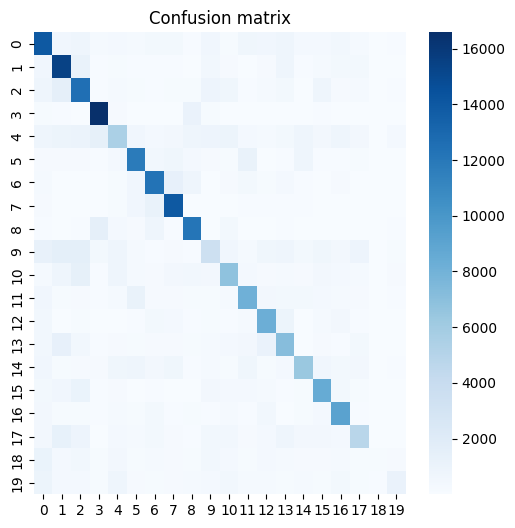

Epoch 0, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.604, Weighted=0.639] 
Balanced Accuracy = 0.612Average loss = 1.14459
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.645   | 0.732  |  0.686   | 2717.0  |
|      1       |   0.729   | 0.765  |  0.747   | 2607.0  |
|      2       |   0.634   | 0.702  |  0.666   | 2445.0  |
|      3       |   0.82    | 0.926  |   0.87   | 2346.0  |
|      4       |   0.489   | 0.447  |  0.467   | 2206.0  |
|      5       |   0.698   | 0.789  |  0.741   | 2191.0  |
|      6       |   0.693   | 0.747  |  0.719   | 2145.0  |
|      7       |   0.814   | 0.836  |  0.825   | 2105.0  |
|      8       |   0.747   | 0.821  |  0.782   | 2017.0  |
|      9       |   0.382   | 0.335  |  0.357   | 1861.0  |
|      10      |   0.643   | 0.511  |   0.57   | 1830.0  |
|      11      |   0.69

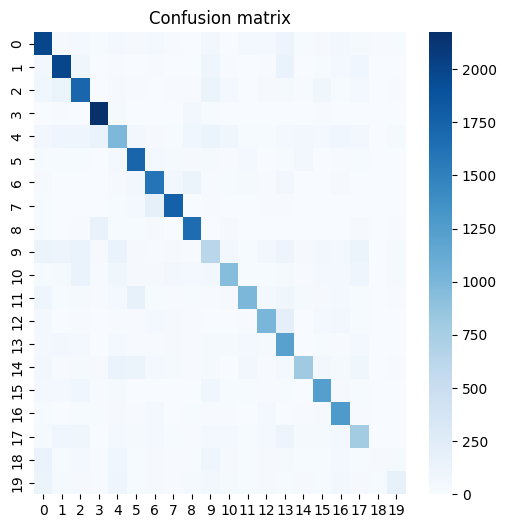

100%|██████████| 9471/9471 [01:47<00:00, 88.42it/s]


Epoch 1, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.608, Weighted=0.641] 
Balanced Accuracy = 0.616Average loss = 1.15649
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.664   | 0.716  |  0.689   | 21738.0  |
|      1       |   0.677   | 0.795  |  0.731   | 20857.0  |
|      2       |   0.627   |  0.7   |  0.662   | 19562.0  |
|      3       |   0.815   | 0.915  |  0.862   | 18766.0  |
|      4       |   0.503   | 0.402  |  0.447   | 17651.0  |
|      5       |   0.728   | 0.756  |  0.741   | 17529.0  |
|      6       |   0.714   | 0.751  |  0.732   | 17159.0  |
|      7       |   0.765   | 0.876  |  0.817   | 16839.0  |
|      8       |   0.762   | 0.815  |  0.788   | 16131.0  |
|      9       |   0.388   | 0.318  |   0.35   | 14887.0  |
|      10      |   0.596   | 0.555  |  0.575   | 14643.0  |
|      11  

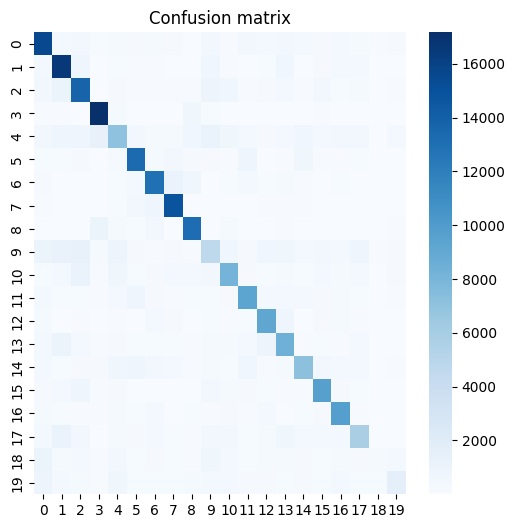

Epoch 1, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.614, Weighted=0.649] 
Balanced Accuracy = 0.624Average loss = 1.10941
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.637   | 0.758  |  0.692   | 2717.0  |
|      1       |   0.686   |  0.83  |  0.751   | 2607.0  |
|      2       |   0.609   | 0.769  |   0.68   | 2445.0  |
|      3       |   0.822   |  0.94  |  0.877   | 2346.0  |
|      4       |   0.544   | 0.413  |   0.47   | 2206.0  |
|      5       |   0.755   | 0.734  |  0.744   | 2191.0  |
|      6       |   0.729   | 0.732  |  0.731   | 2145.0  |
|      7       |   0.755   | 0.916  |  0.828   | 2105.0  |
|      8       |   0.777   | 0.817  |  0.796   | 2017.0  |
|      9       |   0.394   |  0.29  |  0.334   | 1861.0  |
|      10      |   0.615   | 0.562  |  0.588   | 1830.0  |
|      11      |   0.67

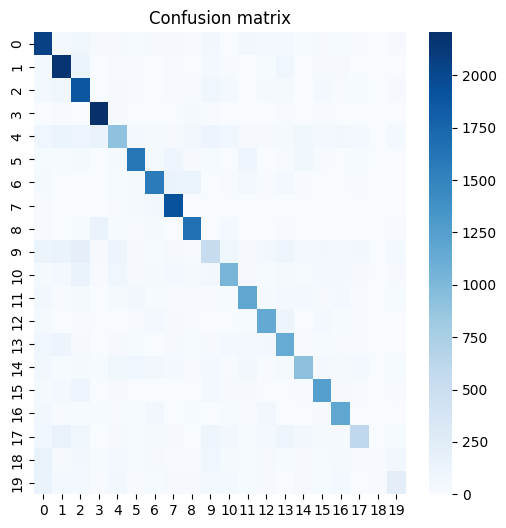

100%|██████████| 9471/9471 [01:47<00:00, 88.21it/s]


Epoch 2, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.619, Weighted=0.652] 
Balanced Accuracy = 0.627Average loss = 1.11948
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.685   | 0.734  |  0.709   | 21738.0  |
|      1       |   0.688   | 0.806  |  0.742   | 20857.0  |
|      2       |   0.638   | 0.711  |  0.673   | 19562.0  |
|      3       |   0.822   | 0.918  |  0.867   | 18766.0  |
|      4       |   0.516   | 0.412  |  0.458   | 17651.0  |
|      5       |   0.734   | 0.759  |  0.746   | 17529.0  |
|      6       |   0.722   | 0.753  |  0.737   | 17159.0  |
|      7       |   0.767   | 0.882  |   0.82   | 16839.0  |
|      8       |   0.773   | 0.826  |  0.799   | 16131.0  |
|      9       |   0.401   | 0.337  |  0.366   | 14887.0  |
|      10      |   0.609   | 0.572  |   0.59   | 14643.0  |
|      11  

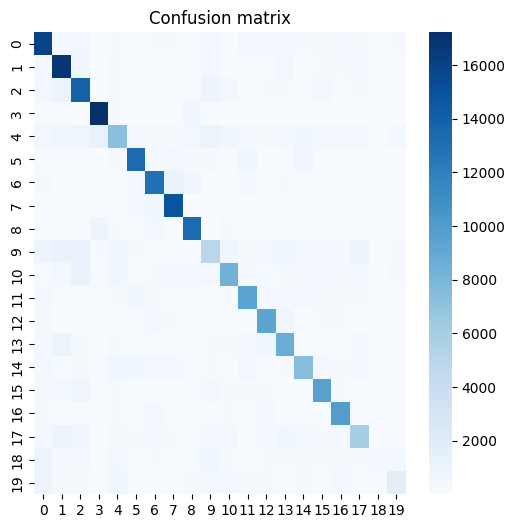

Epoch 2, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.627, Weighted=0.662] 
Balanced Accuracy = 0.635Average loss = 1.07784
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.711   | 0.734  |  0.722   | 2717.0  |
|      1       |   0.723   | 0.833  |  0.774   | 2607.0  |
|      2       |   0.673   | 0.727  |  0.699   | 2445.0  |
|      3       |   0.815   | 0.931  |  0.869   | 2346.0  |
|      4       |   0.535   | 0.438  |  0.482   | 2206.0  |
|      5       |   0.745   |  0.78  |  0.762   | 2191.0  |
|      6       |   0.712   | 0.774  |  0.742   | 2145.0  |
|      7       |   0.749   | 0.923  |  0.827   | 2105.0  |
|      8       |   0.804   | 0.803  |  0.803   | 2017.0  |
|      9       |    0.4    | 0.361  |   0.38   | 1861.0  |
|      10      |   0.636   | 0.567  |   0.6    | 1830.0  |
|      11      |   0.69

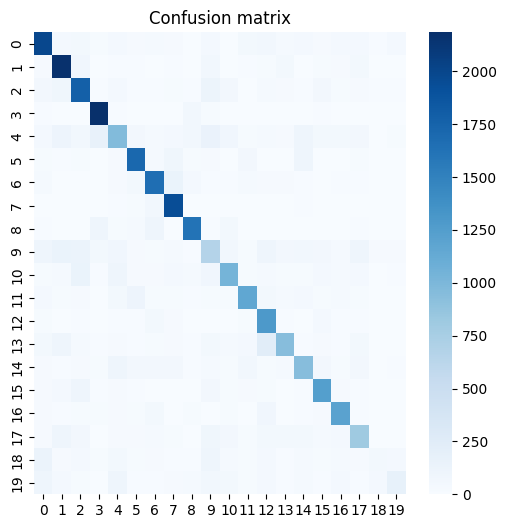

100%|██████████| 9471/9471 [01:46<00:00, 88.69it/s]


Epoch 3, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.627, Weighted=0.659] 
Balanced Accuracy = 0.633Average loss = 1.09760
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.699   | 0.745  |  0.721   | 21738.0  |
|      1       |   0.692   | 0.808  |  0.746   | 20857.0  |
|      2       |   0.642   | 0.714  |  0.676   | 19562.0  |
|      3       |   0.823   | 0.921  |  0.869   | 18766.0  |
|      4       |   0.521   | 0.421  |  0.466   | 17651.0  |
|      5       |   0.748   | 0.767  |  0.757   | 17529.0  |
|      6       |   0.724   |  0.76  |  0.742   | 17159.0  |
|      7       |   0.775   | 0.885  |  0.826   | 16839.0  |
|      8       |   0.779   | 0.826  |  0.802   | 16131.0  |
|      9       |   0.41    | 0.349  |  0.377   | 14887.0  |
|      10      |   0.62    | 0.581  |  0.599   | 14643.0  |
|      11  

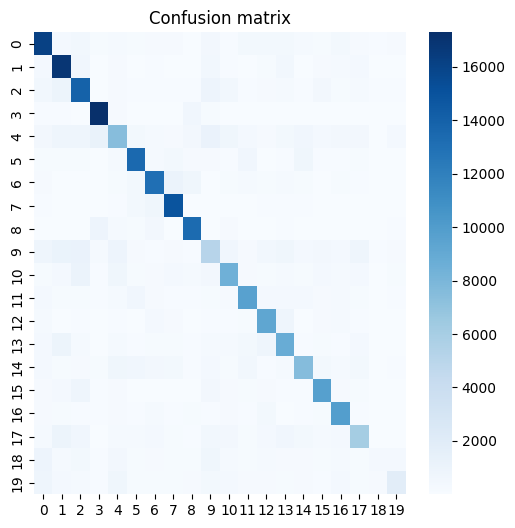

Epoch 3, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.633, Weighted=0.666] 
Balanced Accuracy = 0.642Average loss = 1.05830
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.669   | 0.762  |  0.713   | 2717.0  |
|      1       |   0.693   | 0.844  |  0.761   | 2607.0  |
|      2       |   0.679   | 0.725  |  0.701   | 2445.0  |
|      3       |   0.821   | 0.932  |  0.873   | 2346.0  |
|      4       |   0.589   | 0.413  |  0.486   | 2206.0  |
|      5       |   0.719   | 0.815  |  0.764   | 2191.0  |
|      6       |   0.678   | 0.795  |  0.732   | 2145.0  |
|      7       |   0.848   | 0.832  |   0.84   | 2105.0  |
|      8       |   0.801   | 0.805  |  0.803   | 2017.0  |
|      9       |   0.454   | 0.328  |  0.381   | 1861.0  |
|      10      |   0.596   | 0.613  |  0.604   | 1830.0  |
|      11      |   0.71

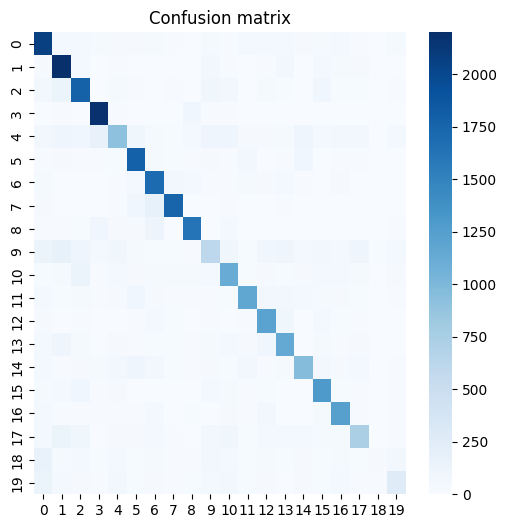

100%|██████████| 9471/9471 [01:47<00:00, 88.49it/s]


Epoch 4, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.635Average loss = 1.08950
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.707   | 0.752  |  0.729   | 21738.0  |
|      1       |   0.693   | 0.811  |  0.748   | 20857.0  |
|      2       |   0.647   | 0.715  |  0.679   | 19562.0  |
|      3       |   0.824   |  0.92  |  0.869   | 18766.0  |
|      4       |   0.524   | 0.423  |  0.468   | 17651.0  |
|      5       |   0.747   |  0.77  |  0.758   | 17529.0  |
|      6       |   0.729   | 0.759  |  0.744   | 17159.0  |
|      7       |   0.772   | 0.883  |  0.824   | 16839.0  |
|      8       |   0.781   | 0.825  |  0.803   | 16131.0  |
|      9       |   0.412   | 0.351  |  0.379   | 14887.0  |
|      10      |   0.621   | 0.587  |  0.604   | 14643.0  |
|      11  

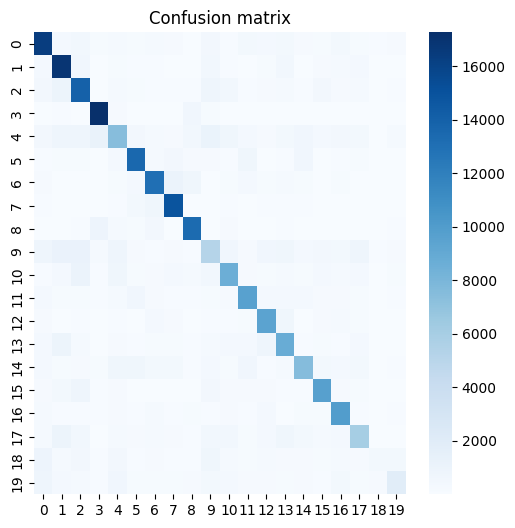

Epoch 4, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.636, Weighted=0.669] 
Balanced Accuracy = 0.644Average loss = 1.06135
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.731   | 0.746  |  0.739   | 2717.0  |
|      1       |   0.708   | 0.815  |  0.758   | 2607.0  |
|      2       |   0.655   | 0.752  |   0.7    | 2445.0  |
|      3       |   0.818   | 0.932  |  0.871   | 2346.0  |
|      4       |   0.554   | 0.436  |  0.488   | 2206.0  |
|      5       |   0.759   | 0.763  |  0.761   | 2191.0  |
|      6       |   0.757   | 0.716  |  0.736   | 2145.0  |
|      7       |   0.752   | 0.932  |  0.833   | 2105.0  |
|      8       |   0.77    | 0.844  |  0.805   | 2017.0  |
|      9       |   0.436   | 0.362  |  0.395   | 1861.0  |
|      10      |   0.685   | 0.563  |  0.618   | 1830.0  |
|      11      |   0.69

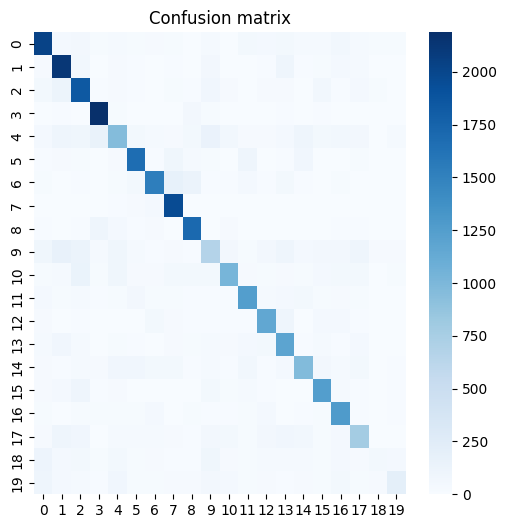

100%|██████████| 9471/9471 [01:48<00:00, 87.10it/s]


Epoch 5, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.08551
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.706   | 0.754  |  0.729   | 21738.0  |
|      1       |   0.696   | 0.809  |  0.749   | 20857.0  |
|      2       |   0.643   | 0.719  |  0.679   | 19562.0  |
|      3       |   0.822   | 0.921  |  0.869   | 18766.0  |
|      4       |   0.532   | 0.426  |  0.473   | 17651.0  |
|      5       |   0.751   | 0.775  |  0.763   | 17529.0  |
|      6       |   0.724   | 0.759  |  0.741   | 17159.0  |
|      7       |   0.771   | 0.893  |  0.827   | 16839.0  |
|      8       |   0.783   | 0.828  |  0.805   | 16131.0  |
|      9       |   0.42    | 0.356  |  0.385   | 14887.0  |
|      10      |   0.628   | 0.587  |  0.607   | 14643.0  |
|      11  

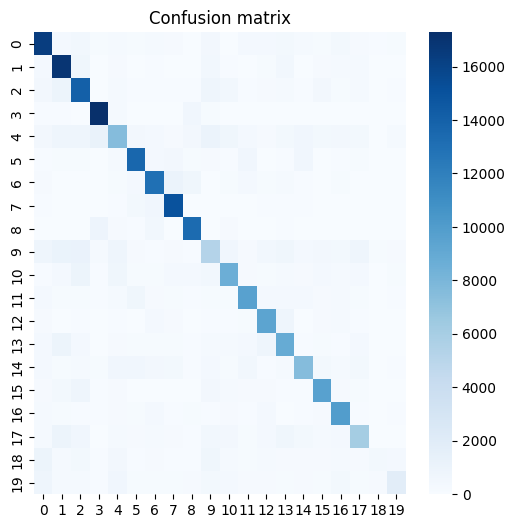

Epoch 5, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.673] 
Balanced Accuracy = 0.645Average loss = 1.05120
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.735   | 0.745  |   0.74   | 2717.0  |
|      1       |   0.723   | 0.827  |  0.771   | 2607.0  |
|      2       |   0.658   | 0.733  |  0.694   | 2445.0  |
|      3       |   0.844   | 0.918  |  0.879   | 2346.0  |
|      4       |   0.524   | 0.481  |  0.501   | 2206.0  |
|      5       |   0.746   | 0.783  |  0.764   | 2191.0  |
|      6       |   0.718   | 0.764  |   0.74   | 2145.0  |
|      7       |   0.791   | 0.886  |  0.836   | 2105.0  |
|      8       |   0.792   | 0.823  |  0.807   | 2017.0  |
|      9       |   0.39    | 0.396  |  0.393   | 1861.0  |
|      10      |   0.64    | 0.606  |  0.623   | 1830.0  |
|      11      |   0.69

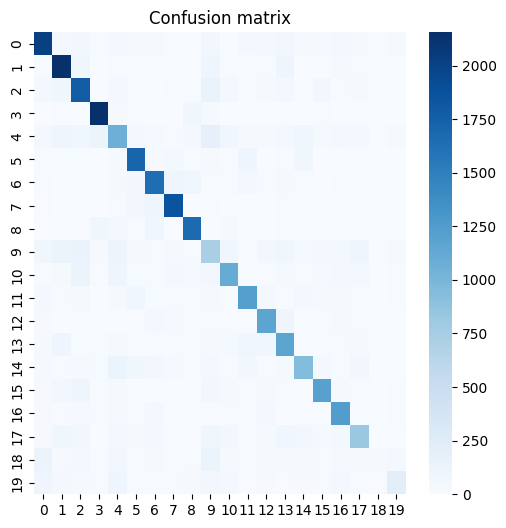

100%|██████████| 9471/9471 [01:47<00:00, 88.17it/s]


Epoch 6, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.632, Weighted=0.664] 
Balanced Accuracy = 0.638Average loss = 1.07941
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.712   | 0.755  |  0.733   | 21738.0  |
|      1       |   0.693   |  0.81  |  0.747   | 20857.0  |
|      2       |   0.64    | 0.723  |  0.679   | 19562.0  |
|      3       |   0.827   | 0.922  |  0.872   | 18766.0  |
|      4       |   0.538   |  0.43  |  0.478   | 17651.0  |
|      5       |   0.755   | 0.771  |  0.763   | 17529.0  |
|      6       |   0.721   | 0.756  |  0.739   | 17159.0  |
|      7       |   0.769   | 0.893  |  0.826   | 16839.0  |
|      8       |   0.782   | 0.827  |  0.803   | 16131.0  |
|      9       |   0.424   | 0.356  |  0.387   | 14887.0  |
|      10      |   0.629   |  0.59  |  0.609   | 14643.0  |
|      11  

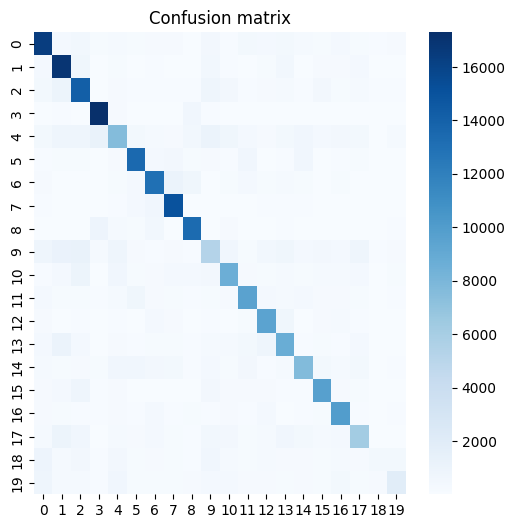

Epoch 6, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.674] 
Balanced Accuracy = 0.647Average loss = 1.04907
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.716   | 0.762  |  0.738   | 2717.0  |
|      1       |   0.727   |  0.83  |  0.775   | 2607.0  |
|      2       |   0.671   | 0.727  |  0.698   | 2445.0  |
|      3       |   0.844   | 0.917  |  0.879   | 2346.0  |
|      4       |   0.586   | 0.438  |  0.501   | 2206.0  |
|      5       |   0.732   | 0.814  |  0.771   | 2191.0  |
|      6       |   0.697   | 0.766  |   0.73   | 2145.0  |
|      7       |   0.822   | 0.869  |  0.845   | 2105.0  |
|      8       |   0.789   | 0.834  |  0.811   | 2017.0  |
|      9       |   0.397   | 0.386  |  0.392   | 1861.0  |
|      10      |   0.624   | 0.608  |  0.616   | 1830.0  |
|      11      |   0.69

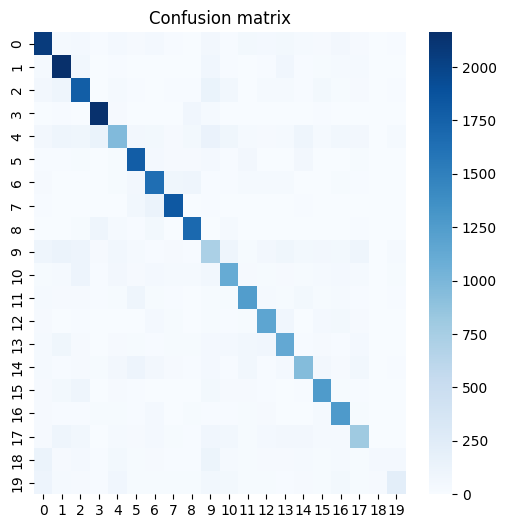

100%|██████████| 9471/9471 [01:47<00:00, 87.89it/s]


Epoch 7, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.632, Weighted=0.663] 
Balanced Accuracy = 0.638Average loss = 1.07879
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   | 0.761  |  0.737   | 21738.0  |
|      1       |   0.693   | 0.809  |  0.746   | 20857.0  |
|      2       |   0.642   |  0.72  |  0.679   | 19562.0  |
|      3       |   0.82    | 0.923  |  0.869   | 18766.0  |
|      4       |   0.541   | 0.423  |  0.475   | 17651.0  |
|      5       |   0.753   | 0.769  |  0.761   | 17529.0  |
|      6       |   0.728   | 0.757  |  0.742   | 17159.0  |
|      7       |   0.765   | 0.888  |  0.822   | 16839.0  |
|      8       |   0.777   | 0.826  |  0.801   | 16131.0  |
|      9       |   0.417   | 0.353  |  0.382   | 14887.0  |
|      10      |   0.634   | 0.592  |  0.612   | 14643.0  |
|      11  

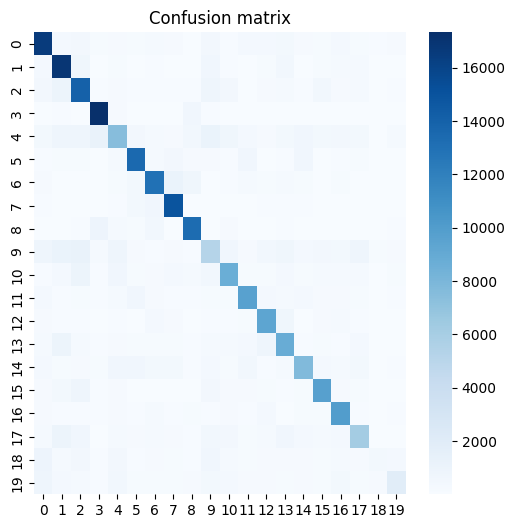

Epoch 7, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.672] 
Balanced Accuracy = 0.646Average loss = 1.04854
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.747   | 0.732  |   0.74   | 2717.0  |
|      1       |   0.684   | 0.857  |  0.761   | 2607.0  |
|      2       |   0.699   | 0.707  |  0.703   | 2445.0  |
|      3       |   0.822   | 0.943  |  0.878   | 2346.0  |
|      4       |   0.566   | 0.427  |  0.486   | 2206.0  |
|      5       |   0.754   |  0.78  |  0.767   | 2191.0  |
|      6       |   0.691   | 0.786  |  0.736   | 2145.0  |
|      7       |   0.775   | 0.891  |  0.829   | 2105.0  |
|      8       |    0.8    | 0.818  |  0.809   | 2017.0  |
|      9       |   0.398   | 0.385  |  0.391   | 1861.0  |
|      10      |   0.605   | 0.616  |  0.611   | 1830.0  |
|      11      |   0.72

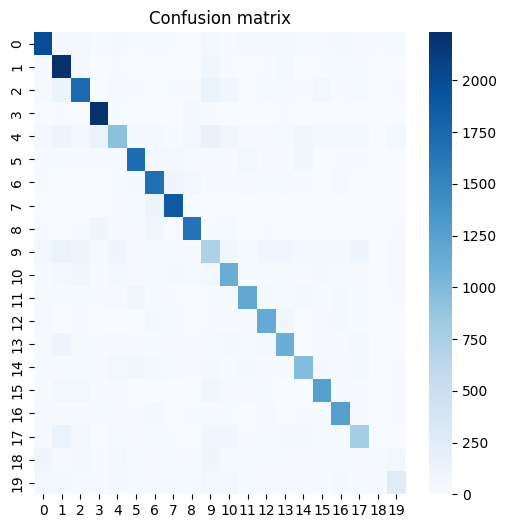

100%|██████████| 9471/9471 [01:48<00:00, 87.25it/s]


Epoch 8, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.633, Weighted=0.664] 
Balanced Accuracy = 0.639Average loss = 1.07425
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   |  0.76  |  0.736   | 21738.0  |
|      1       |   0.69    | 0.817  |  0.748   | 20857.0  |
|      2       |   0.643   | 0.723  |  0.681   | 19562.0  |
|      3       |   0.821   | 0.923  |  0.869   | 18766.0  |
|      4       |   0.543   | 0.427  |  0.478   | 17651.0  |
|      5       |   0.754   | 0.768  |  0.761   | 17529.0  |
|      6       |   0.724   | 0.761  |  0.742   | 17159.0  |
|      7       |   0.766   | 0.892  |  0.824   | 16839.0  |
|      8       |   0.779   | 0.827  |  0.802   | 16131.0  |
|      9       |   0.416   | 0.351  |  0.381   | 14887.0  |
|      10      |   0.636   | 0.587  |   0.61   | 14643.0  |
|      11  

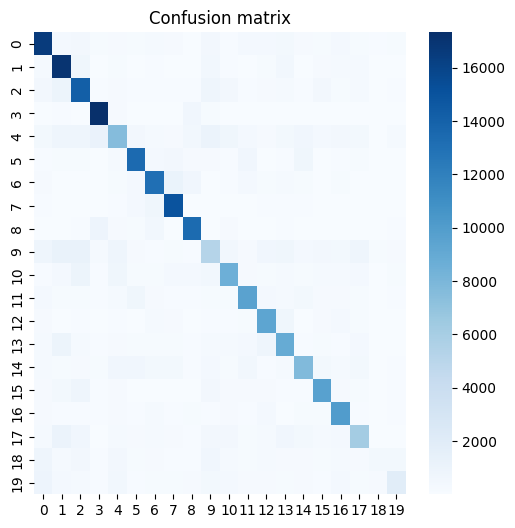

Epoch 8, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.641, Weighted=0.673] 
Balanced Accuracy = 0.647Average loss = 1.05660
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.709   | 0.784  |  0.745   | 2717.0  |
|      1       |   0.698   | 0.845  |  0.764   | 2607.0  |
|      2       |   0.625   | 0.777  |  0.693   | 2445.0  |
|      3       |   0.826   | 0.929  |  0.874   | 2346.0  |
|      4       |   0.578   | 0.433  |  0.495   | 2206.0  |
|      5       |   0.749   | 0.787  |  0.767   | 2191.0  |
|      6       |   0.715   | 0.784  |  0.748   | 2145.0  |
|      7       |   0.792   | 0.904  |  0.844   | 2105.0  |
|      8       |   0.781   | 0.842  |   0.81   | 2017.0  |
|      9       |   0.426   | 0.344  |  0.381   | 1861.0  |
|      10      |   0.654   | 0.595  |  0.623   | 1830.0  |
|      11      |   0.66

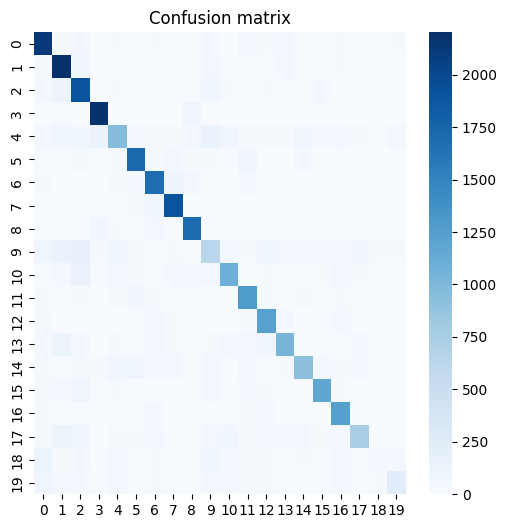

100%|██████████| 9471/9471 [01:48<00:00, 87.61it/s]


Epoch 9, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.631, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07752
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.711   |  0.76  |  0.735   | 21738.0  |
|      1       |   0.683   | 0.815  |  0.743   | 20857.0  |
|      2       |   0.637   | 0.721  |  0.676   | 19562.0  |
|      3       |   0.817   | 0.925  |  0.868   | 18766.0  |
|      4       |   0.539   | 0.418  |  0.471   | 17651.0  |
|      5       |   0.752   | 0.772  |  0.762   | 17529.0  |
|      6       |   0.727   | 0.756  |  0.741   | 17159.0  |
|      7       |   0.765   | 0.891  |  0.824   | 16839.0  |
|      8       |   0.785   | 0.826  |  0.805   | 16131.0  |
|      9       |   0.43    | 0.355  |  0.389   | 14887.0  |
|      10      |   0.631   | 0.594  |  0.612   | 14643.0  |
|      11  

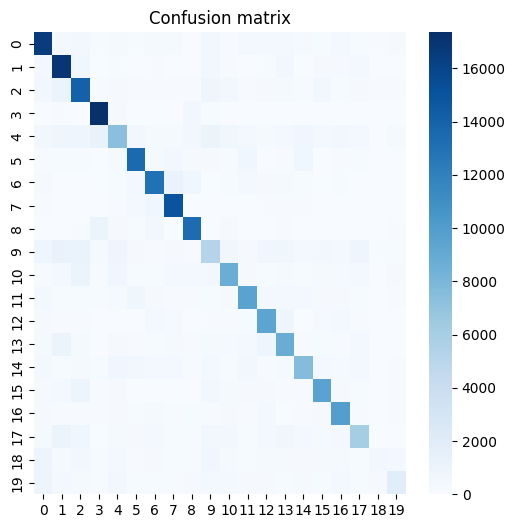

Epoch 9, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.672] 
Balanced Accuracy = 0.647Average loss = 1.05454
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.74    | 0.739  |  0.739   | 2717.0  |
|      1       |   0.717   | 0.836  |  0.772   | 2607.0  |
|      2       |   0.644   | 0.766  |   0.7    | 2445.0  |
|      3       |   0.809   | 0.947  |  0.873   | 2346.0  |
|      4       |   0.541   | 0.442  |  0.486   | 2206.0  |
|      5       |   0.798   | 0.727  |  0.761   | 2191.0  |
|      6       |   0.785   | 0.683  |   0.73   | 2145.0  |
|      7       |   0.754   | 0.943  |  0.838   | 2105.0  |
|      8       |   0.785   |  0.83  |  0.807   | 2017.0  |
|      9       |   0.44    | 0.344  |  0.386   | 1861.0  |
|      10      |   0.636   | 0.585  |  0.609   | 1830.0  |
|      11      |   0.65

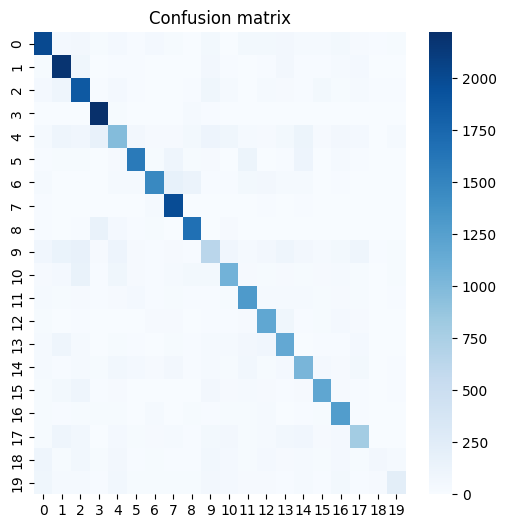

100%|██████████| 9471/9471 [01:48<00:00, 87.17it/s]


Epoch 10, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.632, Weighted=0.663] 
Balanced Accuracy = 0.638Average loss = 1.07553
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   | 0.762  |  0.739   | 21738.0  |
|      1       |   0.689   | 0.816  |  0.747   | 20857.0  |
|      2       |   0.641   | 0.721  |  0.679   | 19562.0  |
|      3       |   0.816   | 0.921  |  0.865   | 18766.0  |
|      4       |   0.545   |  0.43  |  0.481   | 17651.0  |
|      5       |   0.751   |  0.77  |   0.76   | 17529.0  |
|      6       |   0.729   | 0.758  |  0.743   | 17159.0  |
|      7       |   0.765   | 0.892  |  0.824   | 16839.0  |
|      8       |   0.783   | 0.824  |  0.803   | 16131.0  |
|      9       |   0.423   | 0.349  |  0.382   | 14887.0  |
|      10      |   0.628   |  0.59  |  0.608   | 14643.0  |
|      11 

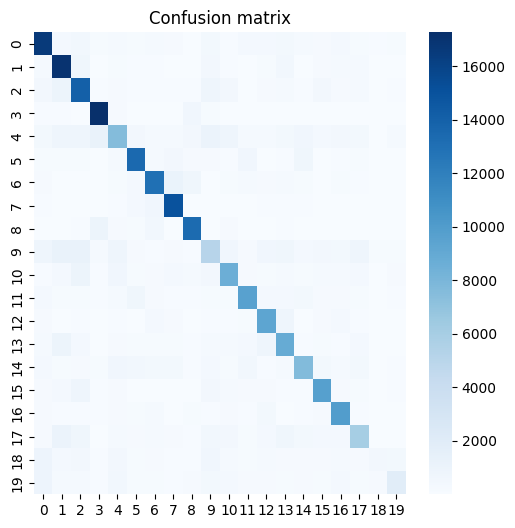

Epoch 10, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.637, Weighted=0.670] 
Balanced Accuracy = 0.645Average loss = 1.05660
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.801   | 0.686  |  0.739   | 2717.0  |
|      1       |   0.703   |  0.83  |  0.761   | 2607.0  |
|      2       |   0.606   | 0.778  |  0.681   | 2445.0  |
|      3       |   0.833   |  0.93  |  0.879   | 2346.0  |
|      4       |   0.56    | 0.429  |  0.486   | 2206.0  |
|      5       |   0.744   | 0.782  |  0.763   | 2191.0  |
|      6       |   0.75    | 0.745  |  0.747   | 2145.0  |
|      7       |   0.745   |  0.92  |  0.824   | 2105.0  |
|      8       |   0.793   | 0.824  |  0.809   | 2017.0  |
|      9       |   0.421   |  0.35  |  0.382   | 1861.0  |
|      10      |   0.644   |  0.61  |  0.626   | 1830.0  |
|      11      |   0.6

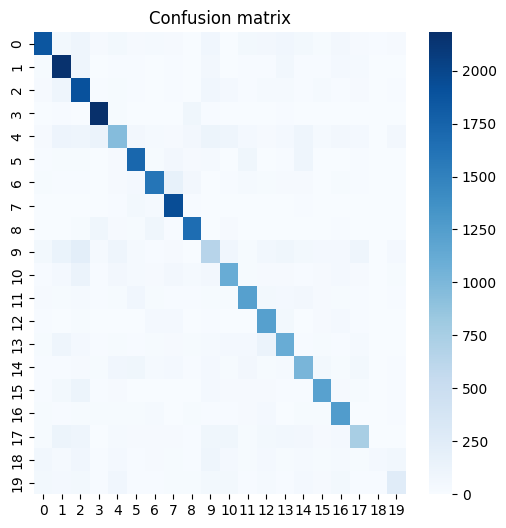

100%|██████████| 9471/9471 [01:48<00:00, 87.42it/s]


Epoch 11, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.631, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07420
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   |  0.76  |  0.738   | 21738.0  |
|      1       |   0.687   | 0.811  |  0.744   | 20857.0  |
|      2       |   0.632   | 0.721  |  0.674   | 19562.0  |
|      3       |   0.821   | 0.921  |  0.868   | 18766.0  |
|      4       |   0.543   | 0.425  |  0.477   | 17651.0  |
|      5       |   0.755   | 0.769  |  0.762   | 17529.0  |
|      6       |   0.724   | 0.757  |   0.74   | 17159.0  |
|      7       |   0.764   |  0.89  |  0.822   | 16839.0  |
|      8       |   0.778   | 0.828  |  0.802   | 16131.0  |
|      9       |   0.425   | 0.348  |  0.383   | 14887.0  |
|      10      |   0.626   | 0.592  |  0.608   | 14643.0  |
|      11 

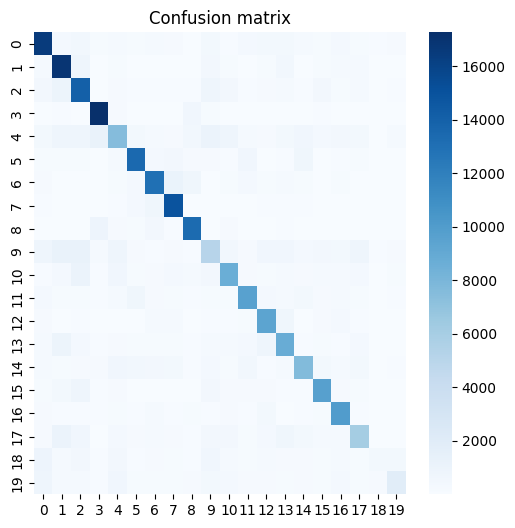

Epoch 11, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.673] 
Balanced Accuracy = 0.645Average loss = 1.04494
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.74    |  0.76  |  0.749   | 2717.0  |
|      1       |   0.725   | 0.826  |  0.772   | 2607.0  |
|      2       |   0.621   | 0.787  |  0.694   | 2445.0  |
|      3       |   0.788   |  0.95  |  0.862   | 2346.0  |
|      4       |   0.553   | 0.458  |  0.501   | 2206.0  |
|      5       |   0.757   | 0.753  |  0.755   | 2191.0  |
|      6       |   0.755   |  0.74  |  0.748   | 2145.0  |
|      7       |   0.777   | 0.919  |  0.842   | 2105.0  |
|      8       |   0.791   |  0.82  |  0.805   | 2017.0  |
|      9       |   0.408   | 0.384  |  0.396   | 1861.0  |
|      10      |   0.672   | 0.583  |  0.624   | 1830.0  |
|      11      |   0.6

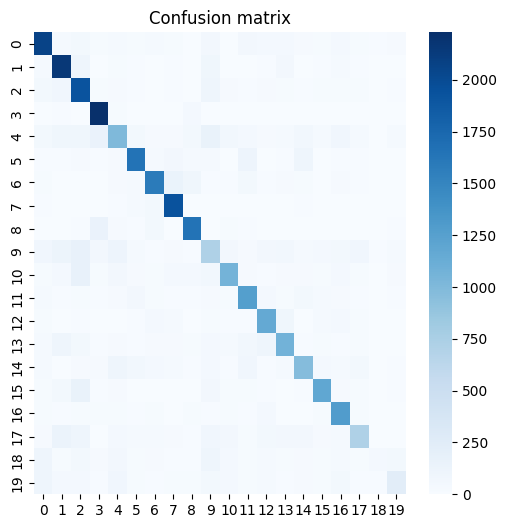

100%|██████████| 9471/9471 [01:50<00:00, 85.66it/s]


Epoch 12, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07807
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.764  |  0.741   | 21738.0  |
|      1       |   0.682   |  0.81  |   0.74   | 20857.0  |
|      2       |   0.632   | 0.723  |  0.674   | 19562.0  |
|      3       |   0.813   | 0.924  |  0.865   | 18766.0  |
|      4       |   0.542   | 0.421  |  0.474   | 17651.0  |
|      5       |   0.751   | 0.767  |  0.759   | 17529.0  |
|      6       |   0.72    | 0.758  |  0.739   | 17159.0  |
|      7       |   0.76    |  0.89  |   0.82   | 16839.0  |
|      8       |   0.781   | 0.824  |  0.802   | 16131.0  |
|      9       |   0.427   | 0.345  |  0.382   | 14887.0  |
|      10      |   0.622   | 0.584  |  0.602   | 14643.0  |
|      11 

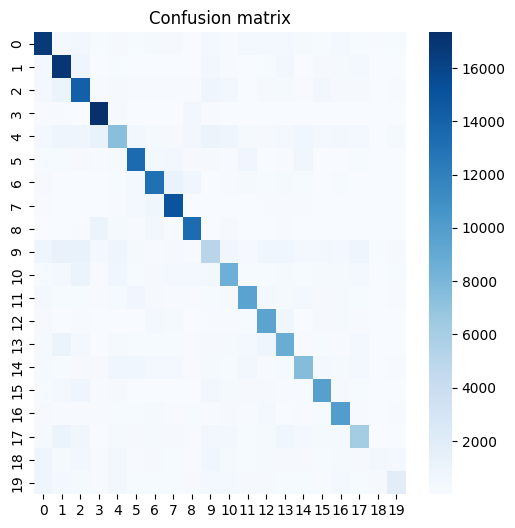

Epoch 12, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.636, Weighted=0.669] 
Balanced Accuracy = 0.645Average loss = 1.04560
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.728   | 0.759  |  0.743   | 2717.0  |
|      1       |   0.684   | 0.861  |  0.762   | 2607.0  |
|      2       |   0.651   | 0.755  |  0.699   | 2445.0  |
|      3       |   0.807   | 0.942  |  0.869   | 2346.0  |
|      4       |   0.572   | 0.427  |  0.489   | 2206.0  |
|      5       |   0.774   | 0.745  |  0.759   | 2191.0  |
|      6       |   0.694   |  0.77  |   0.73   | 2145.0  |
|      7       |   0.771   | 0.905  |  0.833   | 2105.0  |
|      8       |   0.794   | 0.831  |  0.812   | 2017.0  |
|      9       |   0.476   | 0.305  |  0.372   | 1861.0  |
|      10      |   0.622   | 0.614  |  0.618   | 1830.0  |
|      11      |   0.6

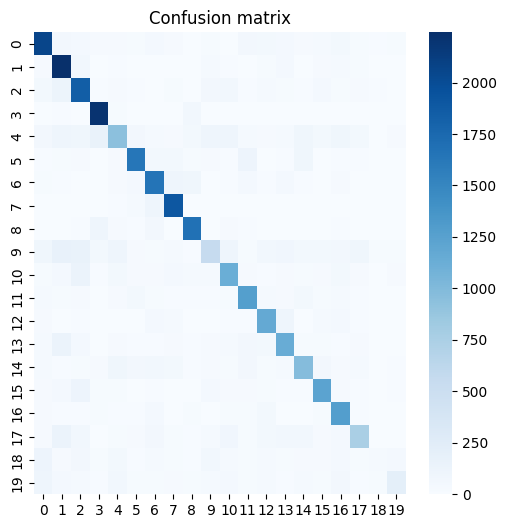

100%|██████████| 9471/9471 [01:49<00:00, 86.80it/s]


Epoch 13, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.631, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07624
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   | 0.764  |  0.738   | 21738.0  |
|      1       |   0.681   | 0.812  |  0.741   | 20857.0  |
|      2       |   0.632   | 0.725  |  0.675   | 19562.0  |
|      3       |   0.816   | 0.923  |  0.866   | 18766.0  |
|      4       |   0.543   | 0.423  |  0.475   | 17651.0  |
|      5       |   0.755   | 0.768  |  0.761   | 17529.0  |
|      6       |   0.72    | 0.761  |   0.74   | 17159.0  |
|      7       |   0.76    | 0.889  |  0.819   | 16839.0  |
|      8       |   0.778   | 0.825  |  0.801   | 16131.0  |
|      9       |   0.43    | 0.343  |  0.381   | 14887.0  |
|      10      |   0.63    | 0.581  |  0.605   | 14643.0  |
|      11 

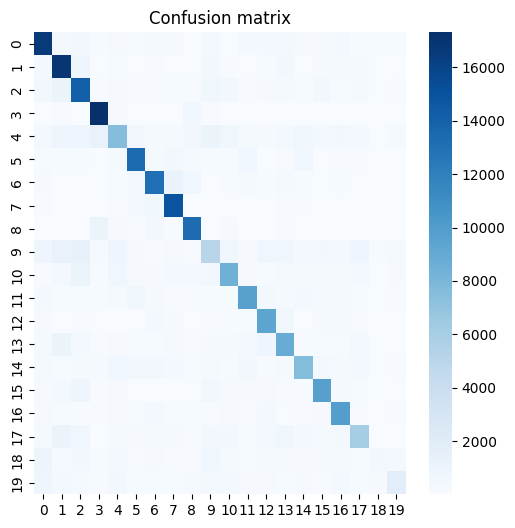

Epoch 13, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.632, Weighted=0.666] 
Balanced Accuracy = 0.641Average loss = 1.04925
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.704   | 0.769  |  0.735   | 2717.0  |
|      1       |   0.694   | 0.843  |  0.762   | 2607.0  |
|      2       |   0.67    | 0.696  |  0.683   | 2445.0  |
|      3       |   0.819   | 0.942  |  0.876   | 2346.0  |
|      4       |   0.578   |  0.44  |   0.5    | 2206.0  |
|      5       |   0.749   | 0.767  |  0.758   | 2191.0  |
|      6       |   0.722   | 0.751  |  0.736   | 2145.0  |
|      7       |   0.776   |  0.9   |  0.833   | 2105.0  |
|      8       |   0.811   | 0.808  |  0.809   | 2017.0  |
|      9       |   0.453   | 0.323  |  0.377   | 1861.0  |
|      10      |   0.581   | 0.644  |  0.611   | 1830.0  |
|      11      |   0.6

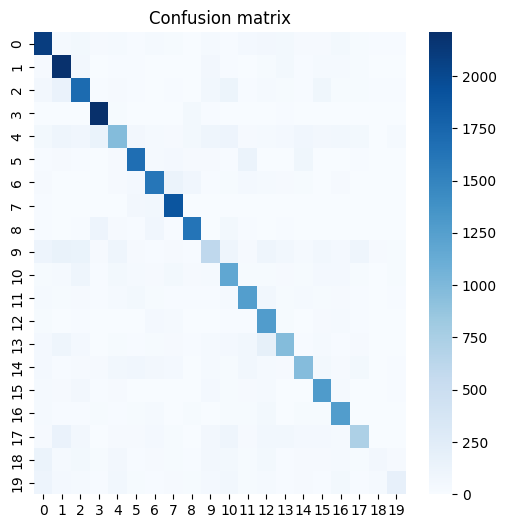

100%|██████████| 9471/9471 [01:49<00:00, 86.44it/s]


Epoch 14, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07990
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.715   |  0.76  |  0.737   | 21738.0  |
|      1       |   0.674   | 0.811  |  0.736   | 20857.0  |
|      2       |   0.63    | 0.719  |  0.672   | 19562.0  |
|      3       |   0.818   | 0.925  |  0.868   | 18766.0  |
|      4       |   0.543   | 0.416  |  0.471   | 17651.0  |
|      5       |   0.758   | 0.767  |  0.762   | 17529.0  |
|      6       |   0.721   |  0.76  |   0.74   | 17159.0  |
|      7       |   0.761   | 0.892  |  0.821   | 16839.0  |
|      8       |   0.78    | 0.826  |  0.802   | 16131.0  |
|      9       |   0.419   | 0.341  |  0.376   | 14887.0  |
|      10      |   0.627   | 0.584  |  0.605   | 14643.0  |
|      11 

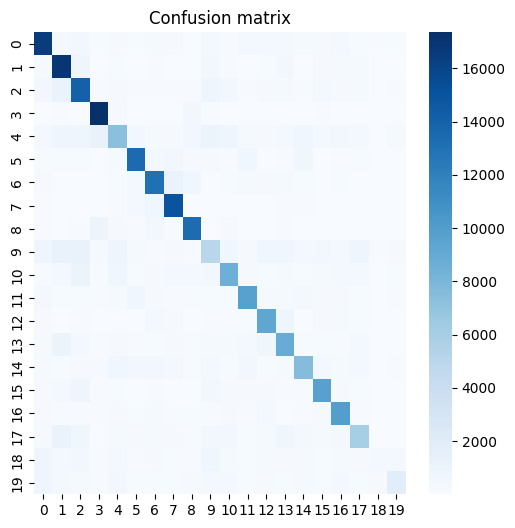

Epoch 14, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.638, Weighted=0.672] 
Balanced Accuracy = 0.645Average loss = 1.04228
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.699   | 0.786  |   0.74   | 2717.0  |
|      1       |   0.733   | 0.819  |  0.774   | 2607.0  |
|      2       |   0.621   | 0.776  |   0.69   | 2445.0  |
|      3       |   0.812   | 0.949  |  0.875   | 2346.0  |
|      4       |   0.552   | 0.467  |  0.506   | 2206.0  |
|      5       |   0.772   | 0.761  |  0.767   | 2191.0  |
|      6       |   0.739   | 0.733  |  0.736   | 2145.0  |
|      7       |   0.767   | 0.904  |  0.829   | 2105.0  |
|      8       |   0.778   | 0.843  |  0.809   | 2017.0  |
|      9       |   0.464   | 0.334  |  0.388   | 1861.0  |
|      10      |   0.649   | 0.596  |  0.621   | 1830.0  |
|      11      |   0.7

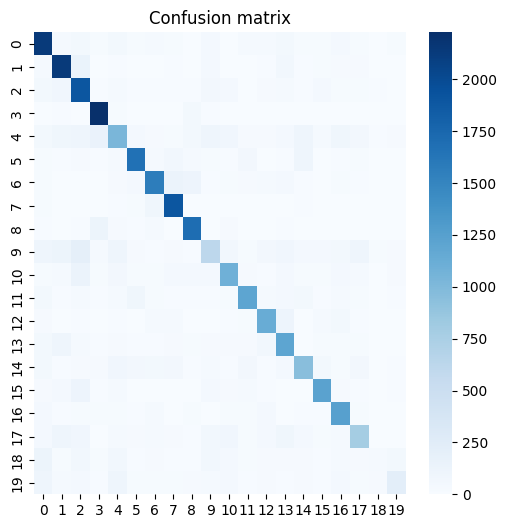

100%|██████████| 9471/9471 [01:50<00:00, 85.43it/s]


Epoch 15, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.08009
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.72    | 0.761  |   0.74   | 21738.0  |
|      1       |   0.68    | 0.811  |   0.74   | 20857.0  |
|      2       |   0.629   | 0.722  |  0.672   | 19562.0  |
|      3       |   0.815   | 0.922  |  0.865   | 18766.0  |
|      4       |   0.55    |  0.42  |  0.476   | 17651.0  |
|      5       |   0.754   | 0.764  |  0.759   | 17529.0  |
|      6       |   0.721   | 0.758  |  0.739   | 17159.0  |
|      7       |   0.76    | 0.889  |  0.819   | 16839.0  |
|      8       |   0.775   | 0.827  |   0.8    | 16131.0  |
|      9       |   0.424   | 0.343  |  0.379   | 14887.0  |
|      10      |   0.634   | 0.585  |  0.608   | 14643.0  |
|      11 

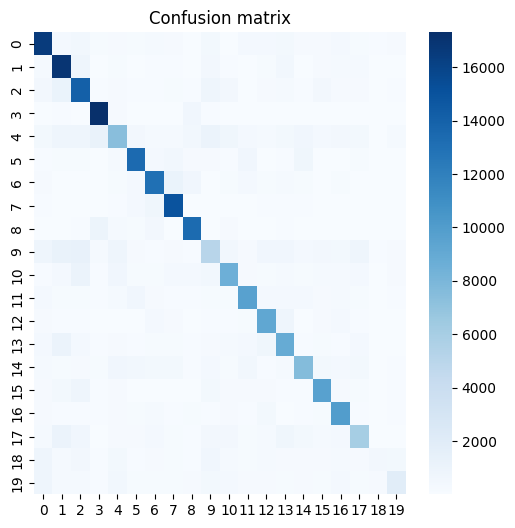

Epoch 15, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.672] 
Balanced Accuracy = 0.646Average loss = 1.04752
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.729   | 0.771  |  0.749   | 2717.0  |
|      1       |   0.716   | 0.823  |  0.766   | 2607.0  |
|      2       |   0.641   | 0.751  |  0.692   | 2445.0  |
|      3       |   0.809   |  0.95  |  0.874   | 2346.0  |
|      4       |   0.578   | 0.443  |  0.502   | 2206.0  |
|      5       |   0.717   | 0.812  |  0.761   | 2191.0  |
|      6       |   0.735   | 0.747  |  0.741   | 2145.0  |
|      7       |   0.783   | 0.908  |  0.841   | 2105.0  |
|      8       |   0.809   | 0.802  |  0.806   | 2017.0  |
|      9       |   0.409   | 0.364  |  0.385   | 1861.0  |
|      10      |   0.675   | 0.583  |  0.626   | 1830.0  |
|      11      |   0.7

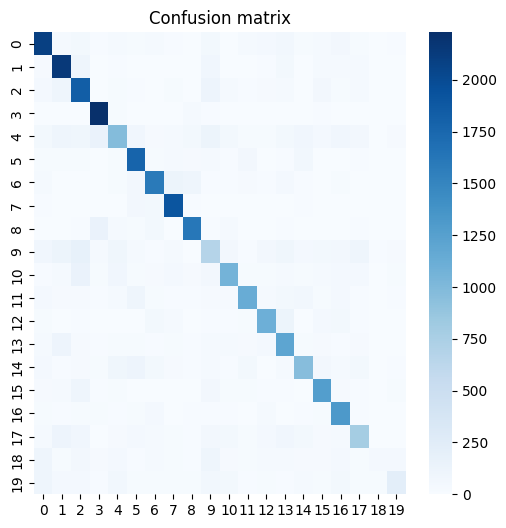

100%|██████████| 9471/9471 [01:50<00:00, 85.81it/s]


Epoch 16, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07983
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   |  0.76  |  0.736   | 21738.0  |
|      1       |   0.678   | 0.813  |  0.739   | 20857.0  |
|      2       |   0.63    |  0.72  |  0.672   | 19562.0  |
|      3       |   0.821   | 0.925  |   0.87   | 18766.0  |
|      4       |   0.549   | 0.421  |  0.476   | 17651.0  |
|      5       |   0.754   | 0.765  |   0.76   | 17529.0  |
|      6       |   0.719   | 0.762  |   0.74   | 17159.0  |
|      7       |   0.754   | 0.887  |  0.815   | 16839.0  |
|      8       |   0.779   | 0.832  |  0.805   | 16131.0  |
|      9       |   0.426   | 0.349  |  0.384   | 14887.0  |
|      10      |   0.628   | 0.583  |  0.605   | 14643.0  |
|      11 

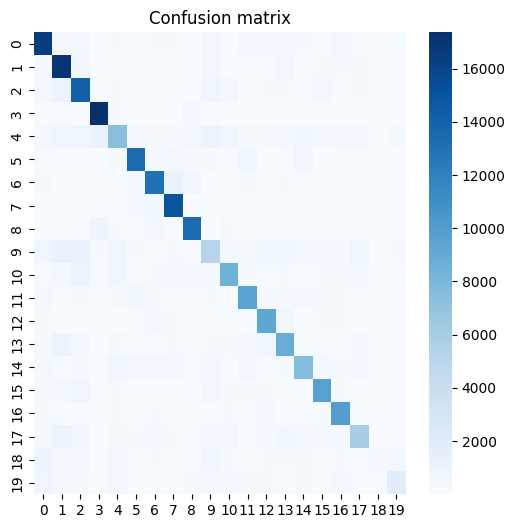

Epoch 16, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.641, Weighted=0.673] 
Balanced Accuracy = 0.648Average loss = 1.04352
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.736   | 0.738  |  0.737   | 2717.0  |
|      1       |   0.708   | 0.839  |  0.768   | 2607.0  |
|      2       |   0.62    | 0.778  |   0.69   | 2445.0  |
|      3       |   0.839   | 0.911  |  0.874   | 2346.0  |
|      4       |   0.596   | 0.437  |  0.505   | 2206.0  |
|      5       |   0.734   | 0.803  |  0.767   | 2191.0  |
|      6       |   0.738   | 0.736  |  0.737   | 2145.0  |
|      7       |   0.799   | 0.896  |  0.845   | 2105.0  |
|      8       |   0.769   | 0.857  |  0.811   | 2017.0  |
|      9       |   0.437   | 0.358  |  0.393   | 1861.0  |
|      10      |   0.624   | 0.609  |  0.616   | 1830.0  |
|      11      |   0.6

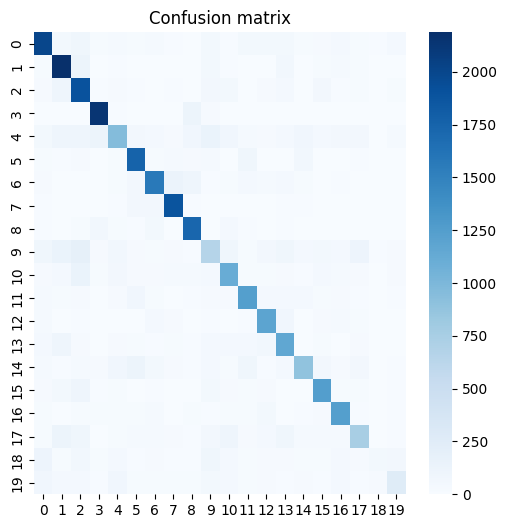

100%|██████████| 9471/9471 [01:50<00:00, 85.61it/s]


Epoch 17, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07886
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.761  |   0.74   | 21738.0  |
|      1       |   0.677   | 0.814  |  0.739   | 20857.0  |
|      2       |   0.627   | 0.727  |  0.673   | 19562.0  |
|      3       |   0.815   | 0.924  |  0.866   | 18766.0  |
|      4       |   0.544   | 0.419  |  0.473   | 17651.0  |
|      5       |   0.75    | 0.767  |  0.758   | 17529.0  |
|      6       |   0.722   | 0.757  |  0.739   | 17159.0  |
|      7       |   0.762   | 0.889  |  0.821   | 16839.0  |
|      8       |   0.781   | 0.824  |  0.802   | 16131.0  |
|      9       |   0.427   |  0.35  |  0.385   | 14887.0  |
|      10      |   0.625   | 0.583  |  0.603   | 14643.0  |
|      11 

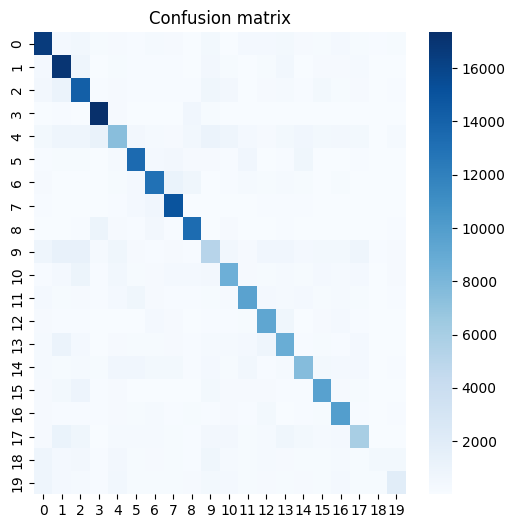

Epoch 17, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.638, Weighted=0.671] 
Balanced Accuracy = 0.645Average loss = 1.05319
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.725   | 0.762  |  0.743   | 2717.0  |
|      1       |   0.659   | 0.873  |  0.751   | 2607.0  |
|      2       |   0.692   | 0.724  |  0.708   | 2445.0  |
|      3       |   0.855   | 0.894  |  0.874   | 2346.0  |
|      4       |   0.583   | 0.433  |  0.497   | 2206.0  |
|      5       |   0.746   | 0.777  |  0.761   | 2191.0  |
|      6       |   0.731   | 0.739  |  0.735   | 2145.0  |
|      7       |   0.772   | 0.908  |  0.834   | 2105.0  |
|      8       |   0.768   | 0.857  |   0.81   | 2017.0  |
|      9       |   0.435   |  0.35  |  0.388   | 1861.0  |
|      10      |   0.635   | 0.609  |  0.622   | 1830.0  |
|      11      |   0.6

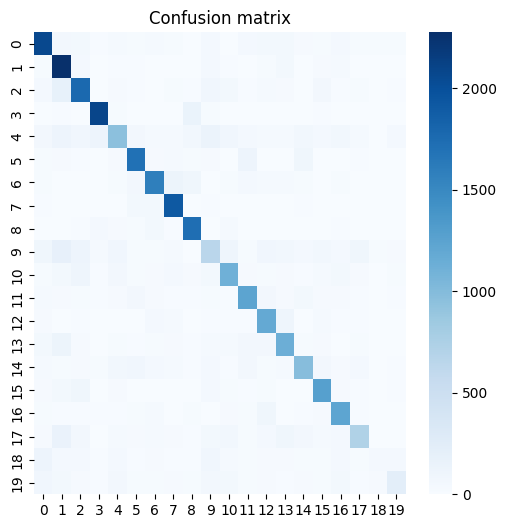

100%|██████████| 9471/9471 [01:50<00:00, 85.60it/s]


Epoch 18, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.636Average loss = 1.08130
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.759  |  0.739   | 21738.0  |
|      1       |   0.685   |  0.81  |  0.742   | 20857.0  |
|      2       |   0.625   | 0.727  |  0.672   | 19562.0  |
|      3       |   0.812   | 0.924  |  0.865   | 18766.0  |
|      4       |   0.547   | 0.424  |  0.478   | 17651.0  |
|      5       |   0.757   | 0.766  |  0.761   | 17529.0  |
|      6       |   0.724   | 0.756  |   0.74   | 17159.0  |
|      7       |   0.756   | 0.892  |  0.818   | 16839.0  |
|      8       |   0.786   |  0.82  |  0.802   | 16131.0  |
|      9       |   0.432   | 0.354  |  0.389   | 14887.0  |
|      10      |   0.635   | 0.583  |  0.608   | 14643.0  |
|      11 

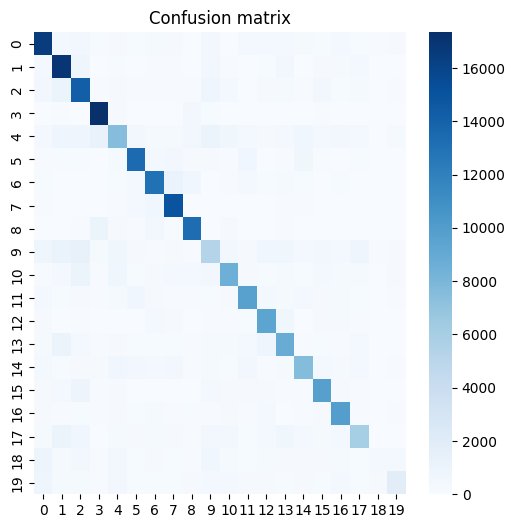

Epoch 18, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.675] 
Balanced Accuracy = 0.647Average loss = 1.05160
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.715   | 0.766  |  0.739   | 2717.0  |
|      1       |   0.718   |  0.84  |  0.774   | 2607.0  |
|      2       |   0.666   | 0.757  |  0.709   | 2445.0  |
|      3       |   0.826   | 0.921  |  0.871   | 2346.0  |
|      4       |   0.597   | 0.418  |  0.492   | 2206.0  |
|      5       |   0.716   | 0.815  |  0.762   | 2191.0  |
|      6       |   0.745   | 0.744  |  0.745   | 2145.0  |
|      7       |   0.789   | 0.899  |   0.84   | 2105.0  |
|      8       |   0.776   | 0.835  |  0.805   | 2017.0  |
|      9       |   0.399   |  0.4   |   0.4    | 1861.0  |
|      10      |   0.667   | 0.589  |  0.625   | 1830.0  |
|      11      |   0.7

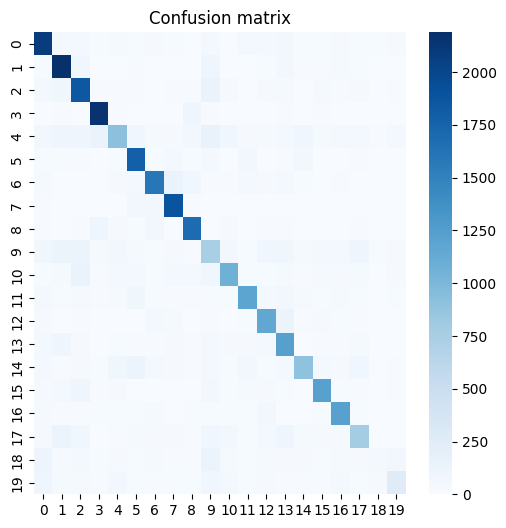

100%|██████████| 9471/9471 [01:52<00:00, 84.39it/s]


Epoch 19, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.628, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08378
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   | 0.761  |  0.739   | 21738.0  |
|      1       |   0.681   | 0.819  |  0.744   | 20857.0  |
|      2       |   0.631   | 0.725  |  0.675   | 19562.0  |
|      3       |   0.813   | 0.925  |  0.865   | 18766.0  |
|      4       |   0.55    | 0.415  |  0.473   | 17651.0  |
|      5       |   0.749   | 0.763  |  0.756   | 17529.0  |
|      6       |   0.718   | 0.756  |  0.736   | 17159.0  |
|      7       |   0.755   | 0.888  |  0.816   | 16839.0  |
|      8       |   0.78    | 0.823  |  0.801   | 16131.0  |
|      9       |   0.425   | 0.345  |  0.381   | 14887.0  |
|      10      |   0.63    | 0.582  |  0.605   | 14643.0  |
|      11 

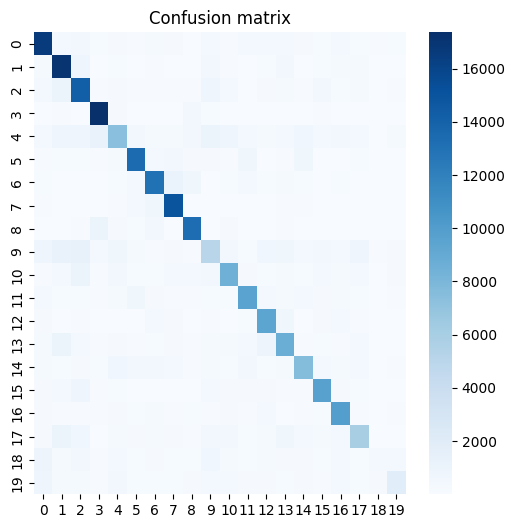

Epoch 19, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.673] 
Balanced Accuracy = 0.647Average loss = 1.04458
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.711   | 0.769  |  0.739   | 2717.0  |
|      1       |   0.689   | 0.864  |  0.767   | 2607.0  |
|      2       |   0.683   | 0.727  |  0.705   | 2445.0  |
|      3       |   0.814   |  0.94  |  0.872   | 2346.0  |
|      4       |   0.593   | 0.434  |  0.501   | 2206.0  |
|      5       |   0.76    | 0.765  |  0.763   | 2191.0  |
|      6       |   0.716   | 0.774  |  0.744   | 2145.0  |
|      7       |   0.794   |  0.9   |  0.844   | 2105.0  |
|      8       |   0.801   | 0.793  |  0.797   | 2017.0  |
|      9       |   0.442   | 0.366  |   0.4    | 1861.0  |
|      10      |   0.625   | 0.609  |  0.617   | 1830.0  |
|      11      |   0.6

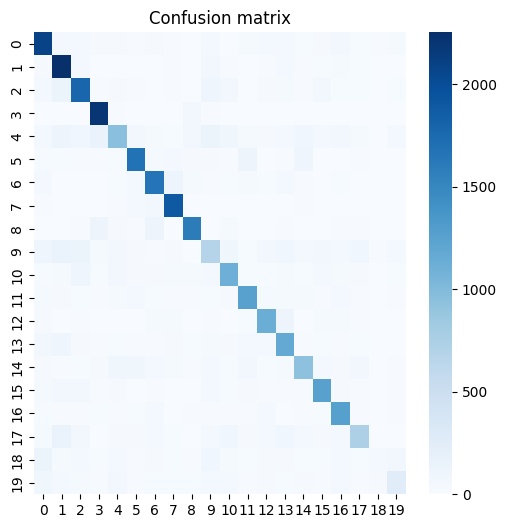

100%|██████████| 9471/9471 [01:51<00:00, 85.32it/s]


Epoch 20, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07858
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.72    | 0.761  |   0.74   | 21738.0  |
|      1       |   0.68    | 0.812  |   0.74   | 20857.0  |
|      2       |   0.629   | 0.727  |  0.674   | 19562.0  |
|      3       |   0.814   | 0.926  |  0.866   | 18766.0  |
|      4       |   0.544   | 0.419  |  0.473   | 17651.0  |
|      5       |   0.755   | 0.766  |   0.76   | 17529.0  |
|      6       |   0.721   | 0.754  |  0.737   | 17159.0  |
|      7       |   0.757   | 0.889  |  0.818   | 16839.0  |
|      8       |   0.777   | 0.826  |  0.801   | 16131.0  |
|      9       |   0.428   | 0.343  |  0.381   | 14887.0  |
|      10      |   0.632   |  0.58  |  0.605   | 14643.0  |
|      11 

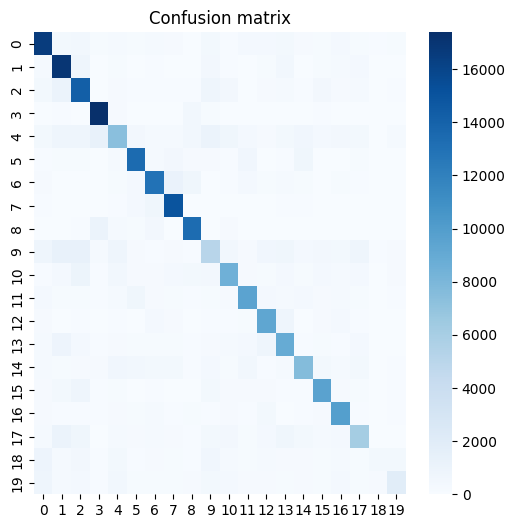

Epoch 20, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.637, Weighted=0.671] 
Balanced Accuracy = 0.645Average loss = 1.04511
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.735   | 0.756  |  0.745   | 2717.0  |
|      1       |   0.742   | 0.823  |   0.78   | 2607.0  |
|      2       |   0.61    | 0.787  |  0.687   | 2445.0  |
|      3       |   0.801   | 0.959  |  0.873   | 2346.0  |
|      4       |   0.576   | 0.432  |  0.493   | 2206.0  |
|      5       |   0.743   | 0.788  |  0.765   | 2191.0  |
|      6       |   0.757   | 0.728  |  0.742   | 2145.0  |
|      7       |   0.774   | 0.916  |  0.839   | 2105.0  |
|      8       |   0.802   | 0.809  |  0.806   | 2017.0  |
|      9       |   0.443   |  0.35  |  0.391   | 1861.0  |
|      10      |   0.641   | 0.603  |  0.621   | 1830.0  |
|      11      |   0.6

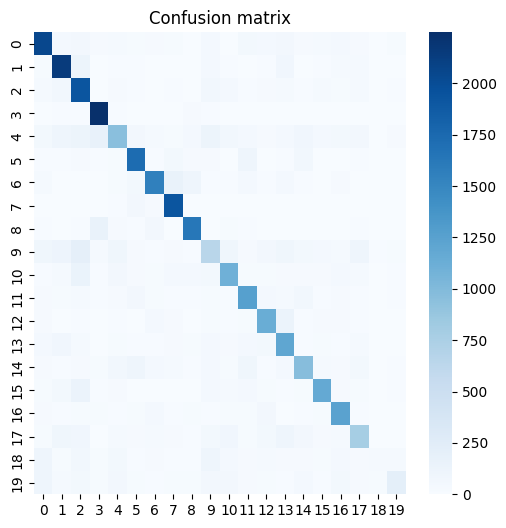

100%|██████████| 9471/9471 [01:51<00:00, 85.06it/s]


Epoch 21, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07777
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   |  0.76  |  0.739   | 21738.0  |
|      1       |   0.68    | 0.812  |   0.74   | 20857.0  |
|      2       |   0.628   | 0.724  |  0.673   | 19562.0  |
|      3       |   0.815   | 0.926  |  0.867   | 18766.0  |
|      4       |   0.551   | 0.424  |  0.479   | 17651.0  |
|      5       |   0.753   | 0.769  |  0.761   | 17529.0  |
|      6       |   0.728   | 0.757  |  0.742   | 17159.0  |
|      7       |   0.757   | 0.889  |  0.818   | 16839.0  |
|      8       |   0.781   | 0.823  |  0.801   | 16131.0  |
|      9       |   0.431   | 0.345  |  0.383   | 14887.0  |
|      10      |   0.63    | 0.585  |  0.606   | 14643.0  |
|      11 

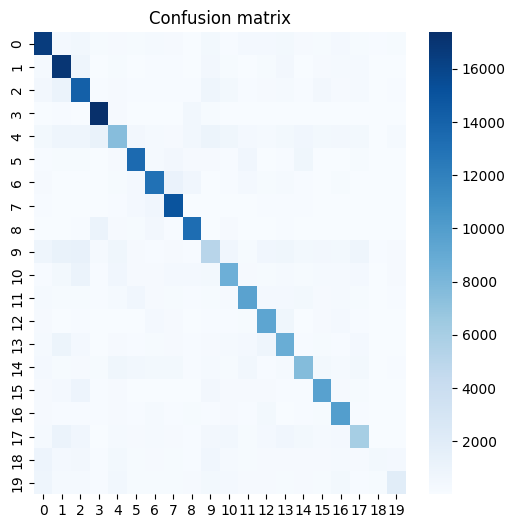

Epoch 21, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.637, Weighted=0.671] 
Balanced Accuracy = 0.644Average loss = 1.04523
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.706   | 0.762  |  0.733   | 2717.0  |
|      1       |   0.709   | 0.835  |  0.767   | 2607.0  |
|      2       |   0.65    | 0.752  |  0.698   | 2445.0  |
|      3       |   0.825   | 0.933  |  0.875   | 2346.0  |
|      4       |   0.578   | 0.437  |  0.498   | 2206.0  |
|      5       |   0.748   | 0.785  |  0.766   | 2191.0  |
|      6       |   0.698   | 0.779  |  0.736   | 2145.0  |
|      7       |   0.798   | 0.883  |  0.838   | 2105.0  |
|      8       |   0.794   | 0.825  |  0.809   | 2017.0  |
|      9       |   0.426   | 0.378  |   0.4    | 1861.0  |
|      10      |   0.637   | 0.584  |  0.609   | 1830.0  |
|      11      |   0.6

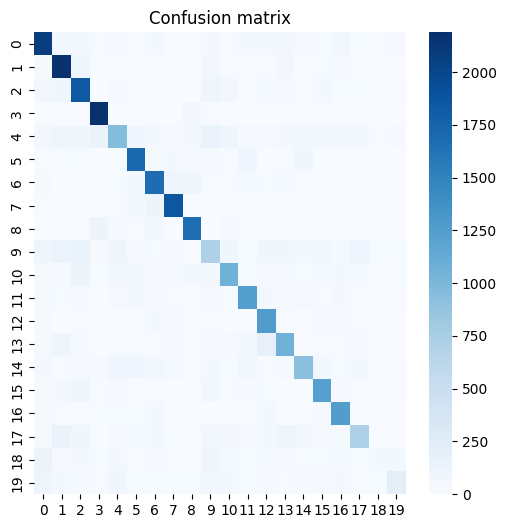

100%|██████████| 9471/9471 [01:52<00:00, 84.55it/s]


Epoch 22, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08203
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.716   |  0.76  |  0.737   | 21738.0  |
|      1       |   0.674   | 0.813  |  0.737   | 20857.0  |
|      2       |   0.624   | 0.723  |   0.67   | 19562.0  |
|      3       |   0.808   | 0.925  |  0.862   | 18766.0  |
|      4       |   0.548   |  0.42  |  0.475   | 17651.0  |
|      5       |   0.755   | 0.769  |  0.762   | 17529.0  |
|      6       |   0.721   | 0.759  |   0.74   | 17159.0  |
|      7       |   0.761   | 0.893  |  0.822   | 16839.0  |
|      8       |   0.779   | 0.822  |   0.8    | 16131.0  |
|      9       |   0.436   | 0.344  |  0.385   | 14887.0  |
|      10      |   0.627   | 0.583  |  0.604   | 14643.0  |
|      11 

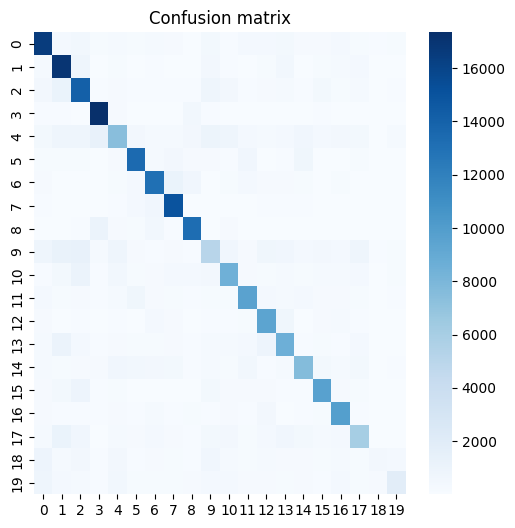

Epoch 22, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.672] 
Balanced Accuracy = 0.646Average loss = 1.04937
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.734   | 0.747  |   0.74   | 2717.0  |
|      1       |   0.696   | 0.844  |  0.763   | 2607.0  |
|      2       |   0.689   |  0.73  |  0.709   | 2445.0  |
|      3       |   0.812   | 0.944  |  0.873   | 2346.0  |
|      4       |   0.538   | 0.462  |  0.497   | 2206.0  |
|      5       |   0.724   | 0.806  |  0.763   | 2191.0  |
|      6       |   0.723   | 0.765  |  0.743   | 2145.0  |
|      7       |   0.782   | 0.906  |   0.84   | 2105.0  |
|      8       |   0.79    | 0.798  |  0.794   | 2017.0  |
|      9       |   0.454   | 0.339  |  0.388   | 1861.0  |
|      10      |   0.632   |  0.6   |  0.616   | 1830.0  |
|      11      |   0.7

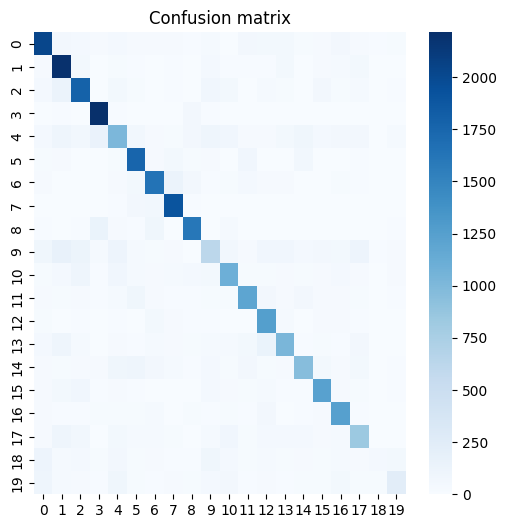

100%|██████████| 9471/9471 [01:51<00:00, 84.63it/s]


Epoch 23, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08097
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   |  0.76  |  0.738   | 21738.0  |
|      1       |   0.674   | 0.813  |  0.737   | 20857.0  |
|      2       |   0.626   | 0.725  |  0.672   | 19562.0  |
|      3       |   0.805   | 0.927  |  0.862   | 18766.0  |
|      4       |   0.545   | 0.422  |  0.476   | 17651.0  |
|      5       |   0.75    | 0.769  |  0.759   | 17529.0  |
|      6       |   0.719   | 0.758  |  0.738   | 17159.0  |
|      7       |   0.76    |  0.89  |   0.82   | 16839.0  |
|      8       |   0.781   | 0.821  |  0.801   | 16131.0  |
|      9       |   0.433   | 0.341  |  0.382   | 14887.0  |
|      10      |   0.63    | 0.582  |  0.605   | 14643.0  |
|      11 

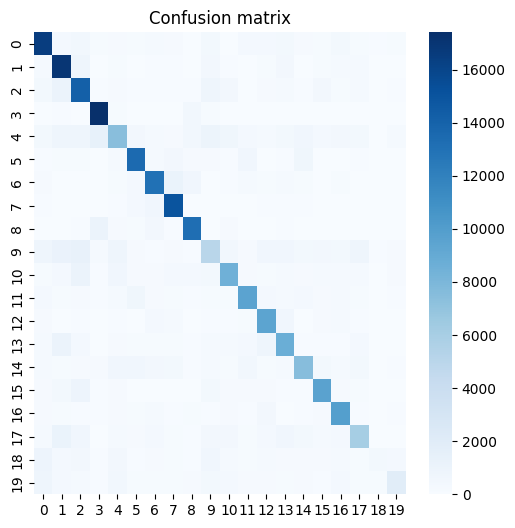

Epoch 23, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.673] 
Balanced Accuracy = 0.645Average loss = 1.04673
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.725   | 0.766  |  0.745   | 2717.0  |
|      1       |   0.687   | 0.852  |   0.76   | 2607.0  |
|      2       |   0.62    |  0.78  |  0.691   | 2445.0  |
|      3       |   0.815   | 0.945  |  0.876   | 2346.0  |
|      4       |   0.582   | 0.432  |  0.496   | 2206.0  |
|      5       |   0.76    | 0.773  |  0.766   | 2191.0  |
|      6       |   0.742   | 0.751  |  0.747   | 2145.0  |
|      7       |   0.753   | 0.925  |   0.83   | 2105.0  |
|      8       |   0.79    | 0.807  |  0.798   | 2017.0  |
|      9       |   0.418   |  0.38  |  0.398   | 1861.0  |
|      10      |   0.648   | 0.575  |   0.61   | 1830.0  |
|      11      |   0.7

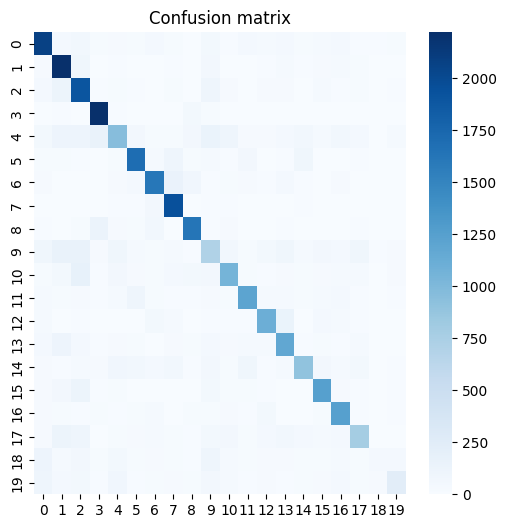

100%|██████████| 9471/9471 [01:52<00:00, 84.49it/s]


Epoch 24, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.628, Weighted=0.660] 
Balanced Accuracy = 0.634Average loss = 1.08204
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.721   | 0.762  |  0.741   | 21738.0  |
|      1       |   0.674   | 0.813  |  0.737   | 20857.0  |
|      2       |   0.628   |  0.72  |  0.671   | 19562.0  |
|      3       |   0.807   | 0.927  |  0.863   | 18766.0  |
|      4       |   0.543   | 0.418  |  0.473   | 17651.0  |
|      5       |   0.754   | 0.766  |   0.76   | 17529.0  |
|      6       |   0.722   | 0.757  |  0.739   | 17159.0  |
|      7       |   0.753   | 0.888  |  0.815   | 16839.0  |
|      8       |   0.78    | 0.822  |   0.8    | 16131.0  |
|      9       |   0.435   | 0.348  |  0.387   | 14887.0  |
|      10      |   0.627   | 0.583  |  0.605   | 14643.0  |
|      11 

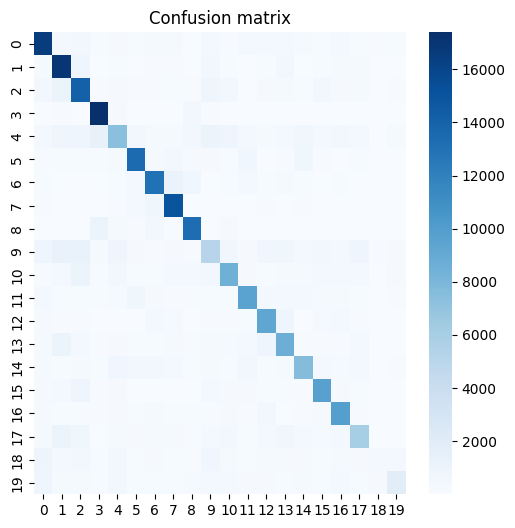

Epoch 24, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.672] 
Balanced Accuracy = 0.647Average loss = 1.04771
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.761   | 0.733  |  0.747   | 2717.0  |
|      1       |   0.691   | 0.834  |  0.756   | 2607.0  |
|      2       |   0.665   | 0.744  |  0.702   | 2445.0  |
|      3       |   0.818   | 0.944  |  0.876   | 2346.0  |
|      4       |   0.533   | 0.471  |   0.5    | 2206.0  |
|      5       |   0.758   |  0.78  |  0.769   | 2191.0  |
|      6       |   0.711   | 0.785  |  0.746   | 2145.0  |
|      7       |   0.777   | 0.909  |  0.838   | 2105.0  |
|      8       |   0.81    | 0.801  |  0.805   | 2017.0  |
|      9       |   0.488   | 0.321  |  0.388   | 1861.0  |
|      10      |   0.601   | 0.619  |   0.61   | 1830.0  |
|      11      |   0.6

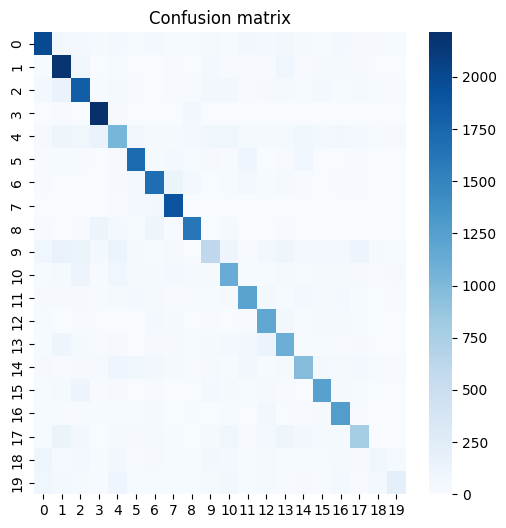

100%|██████████| 9471/9471 [01:52<00:00, 84.21it/s]


Epoch 25, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08244
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.72    | 0.759  |  0.739   | 21738.0  |
|      1       |   0.672   | 0.814  |  0.736   | 20857.0  |
|      2       |   0.627   | 0.721  |   0.67   | 19562.0  |
|      3       |   0.805   | 0.928  |  0.862   | 18766.0  |
|      4       |   0.547   | 0.418  |  0.474   | 17651.0  |
|      5       |   0.75    |  0.77  |   0.76   | 17529.0  |
|      6       |   0.722   | 0.763  |  0.742   | 17159.0  |
|      7       |   0.757   | 0.888  |  0.818   | 16839.0  |
|      8       |   0.783   |  0.82  |  0.801   | 16131.0  |
|      9       |   0.436   | 0.341  |  0.383   | 14887.0  |
|      10      |   0.63    | 0.579  |  0.604   | 14643.0  |
|      11 

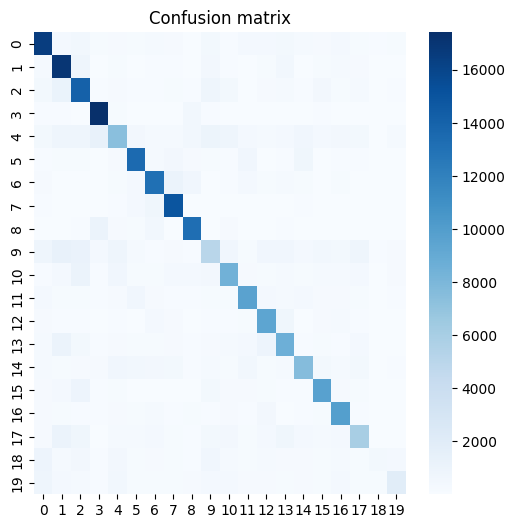

Epoch 25, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.637, Weighted=0.671] 
Balanced Accuracy = 0.644Average loss = 1.04679
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.783   | 0.711  |  0.745   | 2717.0  |
|      1       |   0.714   |  0.83  |  0.768   | 2607.0  |
|      2       |   0.622   | 0.768  |  0.687   | 2445.0  |
|      3       |   0.81    | 0.936  |  0.868   | 2346.0  |
|      4       |   0.564   | 0.462  |  0.508   | 2206.0  |
|      5       |   0.754   | 0.795  |  0.774   | 2191.0  |
|      6       |   0.732   |  0.76  |  0.746   | 2145.0  |
|      7       |   0.805   | 0.891  |  0.846   | 2105.0  |
|      8       |   0.791   | 0.831  |  0.811   | 2017.0  |
|      9       |   0.453   | 0.369  |  0.407   | 1861.0  |
|      10      |    0.6    | 0.609  |  0.604   | 1830.0  |
|      11      |   0.7

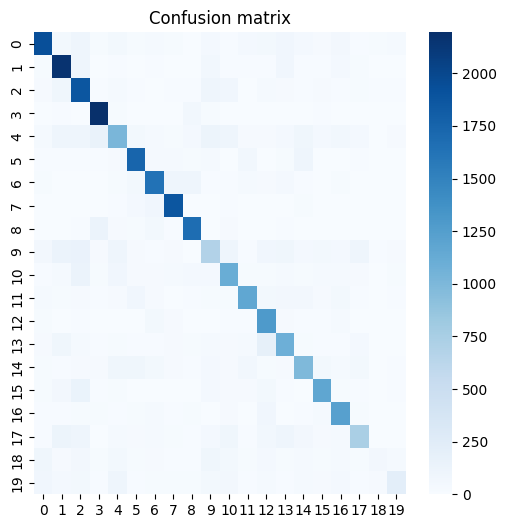

100%|██████████| 9471/9471 [01:52<00:00, 84.00it/s]


Epoch 26, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.636Average loss = 1.08151
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   |  0.76  |  0.738   | 21738.0  |
|      1       |   0.67    | 0.811  |  0.733   | 20857.0  |
|      2       |   0.623   | 0.724  |  0.669   | 19562.0  |
|      3       |   0.809   | 0.928  |  0.864   | 18766.0  |
|      4       |   0.553   | 0.414  |  0.474   | 17651.0  |
|      5       |   0.752   | 0.772  |  0.762   | 17529.0  |
|      6       |   0.722   |  0.76  |  0.741   | 17159.0  |
|      7       |   0.76    | 0.886  |  0.818   | 16839.0  |
|      8       |   0.78    | 0.831  |  0.805   | 16131.0  |
|      9       |   0.433   | 0.338  |   0.38   | 14887.0  |
|      10      |   0.628   | 0.579  |  0.602   | 14643.0  |
|      11 

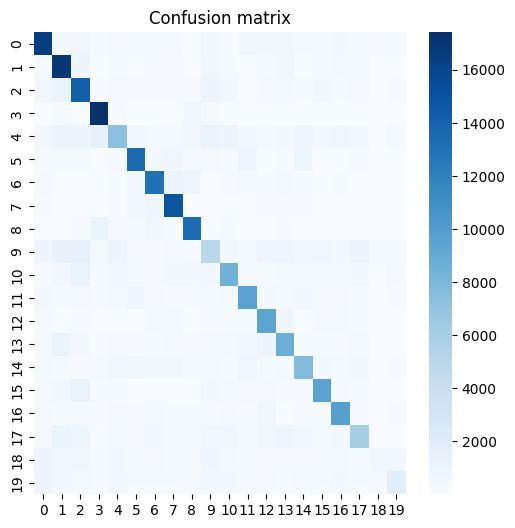

Epoch 26, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.673] 
Balanced Accuracy = 0.648Average loss = 1.04835
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.736   | 0.749  |  0.743   | 2717.0  |
|      1       |   0.702   | 0.835  |  0.762   | 2607.0  |
|      2       |   0.67    | 0.742  |  0.704   | 2445.0  |
|      3       |   0.797   | 0.955  |  0.869   | 2346.0  |
|      4       |   0.613   | 0.411  |  0.492   | 2206.0  |
|      5       |   0.746   |  0.79  |  0.767   | 2191.0  |
|      6       |   0.688   | 0.785  |  0.733   | 2145.0  |
|      7       |   0.79    | 0.893  |  0.839   | 2105.0  |
|      8       |   0.82    | 0.792  |  0.806   | 2017.0  |
|      9       |   0.392   | 0.411  |  0.401   | 1861.0  |
|      10      |   0.641   | 0.604  |  0.622   | 1830.0  |
|      11      |   0.6

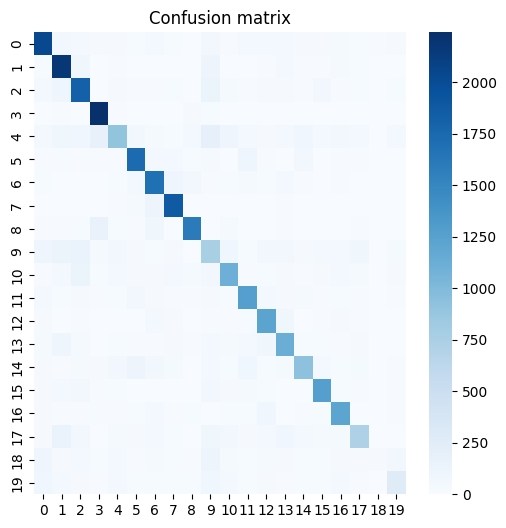

100%|██████████| 9471/9471 [01:52<00:00, 84.11it/s]


Epoch 27, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.628, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08202
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.715   | 0.757  |  0.735   | 21738.0  |
|      1       |   0.672   | 0.816  |  0.737   | 20857.0  |
|      2       |   0.63    | 0.725  |  0.674   | 19562.0  |
|      3       |   0.804   | 0.931  |  0.863   | 18766.0  |
|      4       |   0.546   | 0.417  |  0.473   | 17651.0  |
|      5       |   0.756   | 0.767  |  0.761   | 17529.0  |
|      6       |   0.718   | 0.763  |   0.74   | 17159.0  |
|      7       |   0.763   | 0.887  |   0.82   | 16839.0  |
|      8       |   0.784   | 0.821  |  0.802   | 16131.0  |
|      9       |   0.433   | 0.345  |  0.384   | 14887.0  |
|      10      |   0.632   | 0.581  |  0.605   | 14643.0  |
|      11 

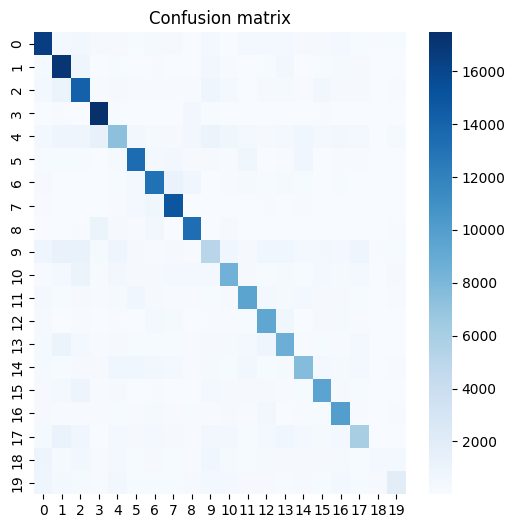

Epoch 27, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.672] 
Balanced Accuracy = 0.647Average loss = 1.04598
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.776   | 0.719  |  0.746   | 2717.0  |
|      1       |   0.692   | 0.847  |  0.762   | 2607.0  |
|      2       |   0.64    |  0.74  |  0.687   | 2445.0  |
|      3       |   0.819   | 0.938  |  0.875   | 2346.0  |
|      4       |   0.583   | 0.445  |  0.505   | 2206.0  |
|      5       |   0.748   | 0.793  |   0.77   | 2191.0  |
|      6       |   0.712   | 0.771  |   0.74   | 2145.0  |
|      7       |   0.775   | 0.915  |   0.84   | 2105.0  |
|      8       |   0.798   | 0.826  |  0.812   | 2017.0  |
|      9       |   0.418   | 0.353  |  0.383   | 1861.0  |
|      10      |   0.609   | 0.601  |  0.605   | 1830.0  |
|      11      |   0.6

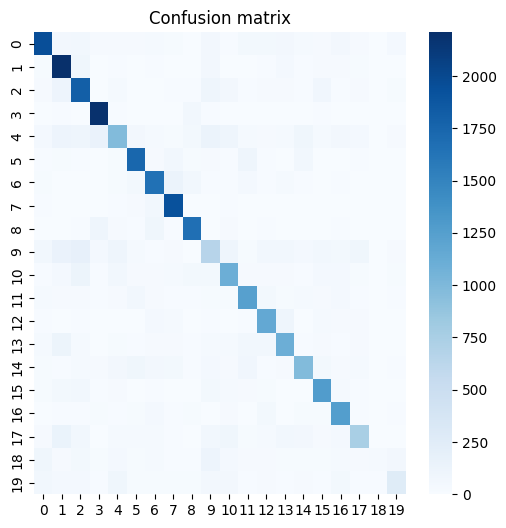

100%|██████████| 9471/9471 [01:53<00:00, 83.67it/s]


Epoch 28, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.628, Weighted=0.660] 
Balanced Accuracy = 0.634Average loss = 1.08269
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   | 0.761  |  0.739   | 21738.0  |
|      1       |   0.67    | 0.812  |  0.734   | 20857.0  |
|      2       |   0.628   | 0.723  |  0.672   | 19562.0  |
|      3       |   0.806   | 0.925  |  0.862   | 18766.0  |
|      4       |   0.55    |  0.42  |  0.476   | 17651.0  |
|      5       |   0.751   | 0.773  |  0.762   | 17529.0  |
|      6       |   0.721   | 0.765  |  0.742   | 17159.0  |
|      7       |   0.759   | 0.889  |  0.819   | 16839.0  |
|      8       |   0.78    | 0.819  |  0.799   | 16131.0  |
|      9       |   0.434   |  0.35  |  0.388   | 14887.0  |
|      10      |   0.629   | 0.578  |  0.602   | 14643.0  |
|      11 

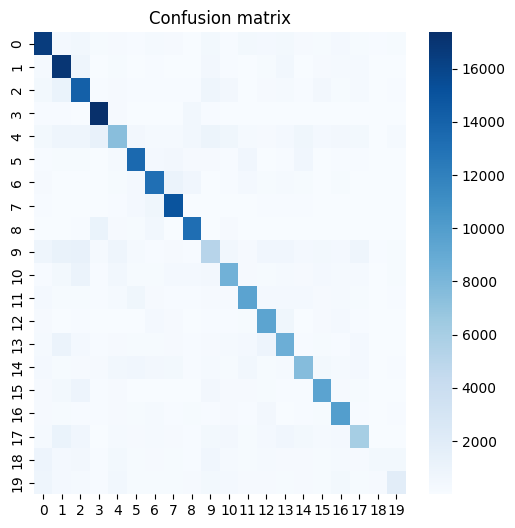

Epoch 28, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.674] 
Balanced Accuracy = 0.648Average loss = 1.04464
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.726   | 0.759  |  0.742   | 2717.0  |
|      1       |   0.715   |  0.84  |  0.772   | 2607.0  |
|      2       |   0.633   | 0.768  |  0.694   | 2445.0  |
|      3       |   0.813   | 0.946  |  0.875   | 2346.0  |
|      4       |   0.554   | 0.453  |  0.499   | 2206.0  |
|      5       |   0.761   |  0.78  |   0.77   | 2191.0  |
|      6       |   0.743   | 0.745  |  0.744   | 2145.0  |
|      7       |   0.778   | 0.903  |  0.836   | 2105.0  |
|      8       |   0.78    | 0.847  |  0.812   | 2017.0  |
|      9       |   0.438   |  0.37  |  0.401   | 1861.0  |
|      10      |   0.698   | 0.553  |  0.617   | 1830.0  |
|      11      |   0.6

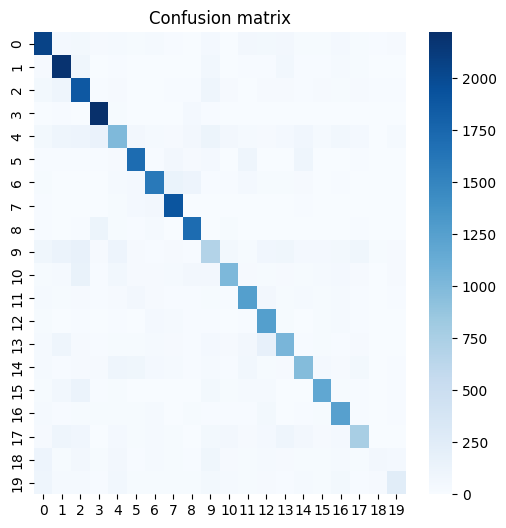

100%|██████████| 9471/9471 [01:53<00:00, 83.66it/s]


Epoch 29, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.07897
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.761  |  0.739   | 21738.0  |
|      1       |   0.673   | 0.815  |  0.737   | 20857.0  |
|      2       |   0.628   | 0.716  |  0.669   | 19562.0  |
|      3       |   0.804   | 0.928  |  0.862   | 18766.0  |
|      4       |   0.547   | 0.416  |  0.473   | 17651.0  |
|      5       |   0.755   | 0.765  |   0.76   | 17529.0  |
|      6       |   0.721   | 0.765  |  0.742   | 17159.0  |
|      7       |   0.759   | 0.892  |   0.82   | 16839.0  |
|      8       |   0.781   |  0.82  |   0.8    | 16131.0  |
|      9       |   0.427   | 0.347  |  0.383   | 14887.0  |
|      10      |   0.631   | 0.581  |  0.605   | 14643.0  |
|      11 

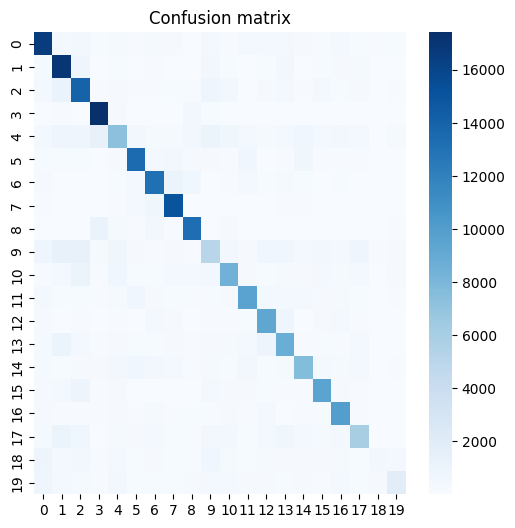

Epoch 29, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.675] 
Balanced Accuracy = 0.648Average loss = 1.04462
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.75    | 0.742  |  0.746   | 2717.0  |
|      1       |   0.726   | 0.817  |  0.768   | 2607.0  |
|      2       |   0.686   | 0.719  |  0.702   | 2445.0  |
|      3       |   0.802   | 0.937  |  0.865   | 2346.0  |
|      4       |   0.555   | 0.449  |  0.497   | 2206.0  |
|      5       |   0.719   | 0.825  |  0.769   | 2191.0  |
|      6       |   0.741   | 0.749  |  0.745   | 2145.0  |
|      7       |   0.775   | 0.898  |  0.832   | 2105.0  |
|      8       |   0.776   | 0.822  |  0.798   | 2017.0  |
|      9       |   0.416   |  0.4   |  0.408   | 1861.0  |
|      10      |   0.668   | 0.581  |  0.622   | 1830.0  |
|      11      |   0.7

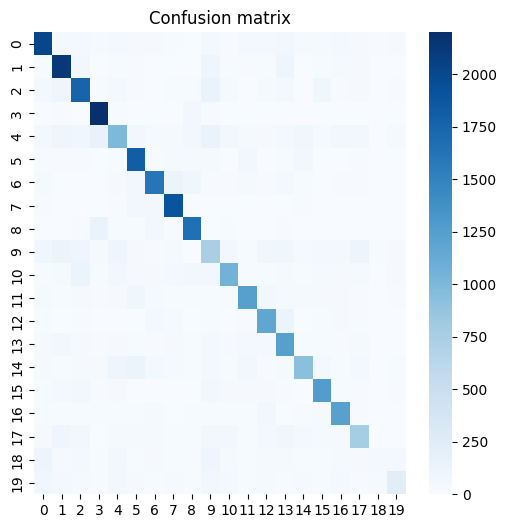

100%|██████████| 9471/9471 [01:53<00:00, 83.67it/s]


Epoch 30, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.628, Weighted=0.659] 
Balanced Accuracy = 0.634Average loss = 1.08112
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   |  0.76  |  0.736   | 21738.0  |
|      1       |   0.671   | 0.812  |  0.735   | 20857.0  |
|      2       |   0.634   |  0.72  |  0.674   | 19562.0  |
|      3       |   0.804   | 0.926  |  0.861   | 18766.0  |
|      4       |   0.545   | 0.418  |  0.473   | 17651.0  |
|      5       |   0.754   | 0.769  |  0.762   | 17529.0  |
|      6       |   0.718   | 0.758  |  0.737   | 17159.0  |
|      7       |   0.753   | 0.891  |  0.816   | 16839.0  |
|      8       |   0.78    | 0.818  |  0.799   | 16131.0  |
|      9       |   0.433   | 0.349  |  0.386   | 14887.0  |
|      10      |   0.63    | 0.578  |  0.603   | 14643.0  |
|      11 

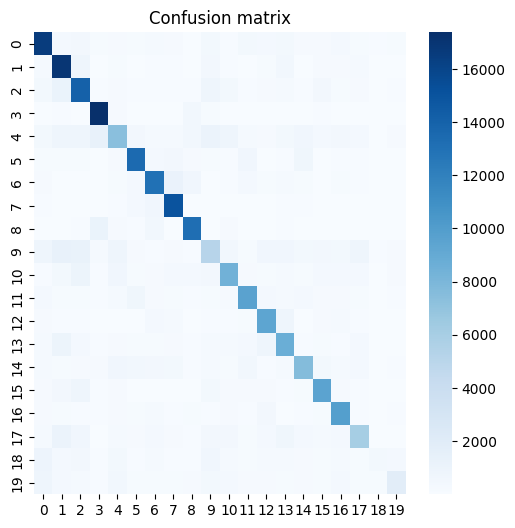

Epoch 30, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.673] 
Balanced Accuracy = 0.646Average loss = 1.04361
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.735   | 0.736  |  0.736   | 2717.0  |
|      1       |   0.688   |  0.85  |   0.76   | 2607.0  |
|      2       |   0.656   | 0.763  |  0.706   | 2445.0  |
|      3       |   0.807   |  0.94  |  0.868   | 2346.0  |
|      4       |   0.578   | 0.424  |  0.489   | 2206.0  |
|      5       |   0.758   | 0.769  |  0.763   | 2191.0  |
|      6       |   0.706   | 0.782  |  0.742   | 2145.0  |
|      7       |   0.792   | 0.886  |  0.836   | 2105.0  |
|      8       |   0.793   |  0.81  |  0.802   | 2017.0  |
|      9       |   0.418   | 0.389  |  0.403   | 1861.0  |
|      10      |   0.64    | 0.601  |   0.62   | 1830.0  |
|      11      |   0.6

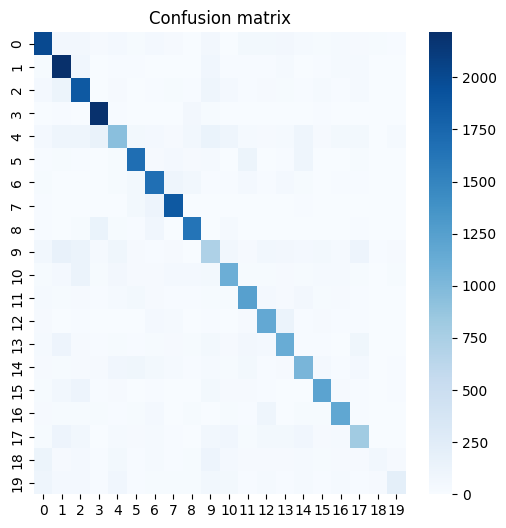

100%|██████████| 9471/9471 [01:53<00:00, 83.22it/s]


Epoch 31, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.660] 
Balanced Accuracy = 0.635Average loss = 1.08135
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.715   | 0.761  |  0.737   | 21738.0  |
|      1       |   0.669   | 0.812  |  0.734   | 20857.0  |
|      2       |   0.632   | 0.724  |  0.675   | 19562.0  |
|      3       |   0.81    | 0.926  |  0.864   | 18766.0  |
|      4       |   0.549   | 0.417  |  0.474   | 17651.0  |
|      5       |   0.748   | 0.771  |  0.759   | 17529.0  |
|      6       |   0.72    | 0.762  |   0.74   | 17159.0  |
|      7       |   0.76    |  0.89  |   0.82   | 16839.0  |
|      8       |   0.777   | 0.821  |  0.798   | 16131.0  |
|      9       |   0.433   | 0.348  |  0.386   | 14887.0  |
|      10      |   0.627   | 0.578  |  0.602   | 14643.0  |
|      11 

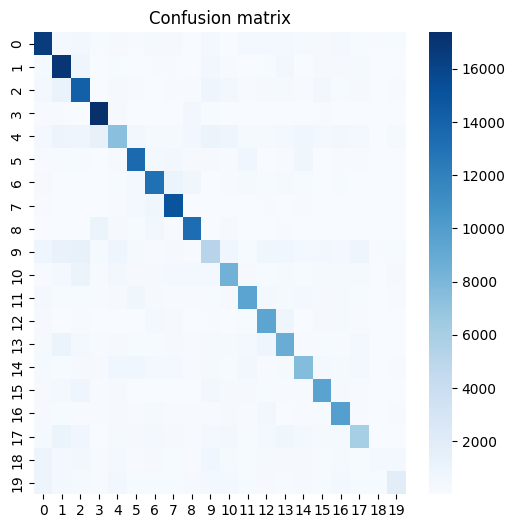

Epoch 31, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.674] 
Balanced Accuracy = 0.648Average loss = 1.04181
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.729   | 0.767  |  0.748   | 2717.0  |
|      1       |   0.703   | 0.845  |  0.768   | 2607.0  |
|      2       |   0.665   |  0.74  |   0.7    | 2445.0  |
|      3       |   0.816   | 0.933  |  0.871   | 2346.0  |
|      4       |   0.574   | 0.433  |  0.494   | 2206.0  |
|      5       |   0.746   | 0.804  |  0.774   | 2191.0  |
|      6       |   0.713   | 0.756  |  0.734   | 2145.0  |
|      7       |   0.805   | 0.875  |  0.839   | 2105.0  |
|      8       |   0.759   | 0.839  |  0.797   | 2017.0  |
|      9       |   0.416   | 0.406  |  0.411   | 1861.0  |
|      10      |   0.663   | 0.573  |  0.615   | 1830.0  |
|      11      |   0.6

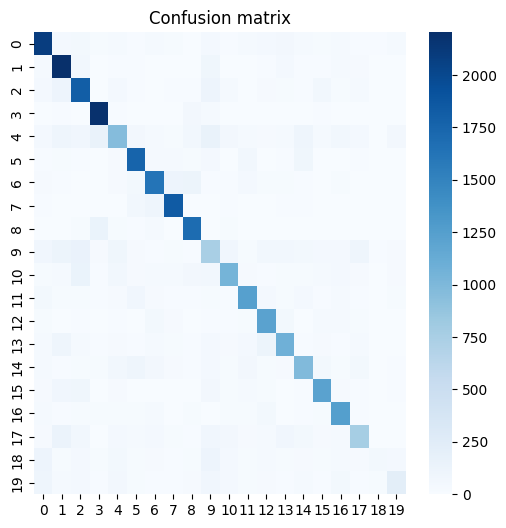

100%|██████████| 9471/9471 [01:53<00:00, 83.23it/s]


Epoch 32, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07982
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.762  |   0.74   | 21738.0  |
|      1       |   0.673   | 0.816  |  0.737   | 20857.0  |
|      2       |   0.636   | 0.723  |  0.677   | 19562.0  |
|      3       |   0.809   | 0.926  |  0.863   | 18766.0  |
|      4       |   0.551   | 0.418  |  0.475   | 17651.0  |
|      5       |   0.755   | 0.774  |  0.764   | 17529.0  |
|      6       |   0.717   | 0.757  |  0.737   | 17159.0  |
|      7       |   0.755   | 0.888  |  0.816   | 16839.0  |
|      8       |   0.78    | 0.827  |  0.803   | 16131.0  |
|      9       |   0.428   | 0.347  |  0.383   | 14887.0  |
|      10      |   0.628   | 0.578  |  0.602   | 14643.0  |
|      11 

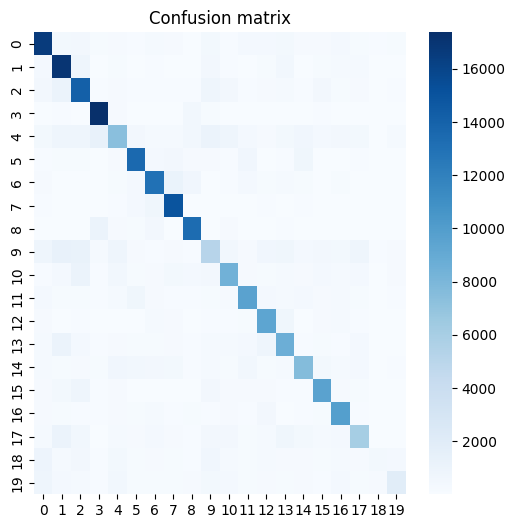

Epoch 32, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.673] 
Balanced Accuracy = 0.647Average loss = 1.04409
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.752   | 0.742  |  0.747   | 2717.0  |
|      1       |   0.722   | 0.821  |  0.768   | 2607.0  |
|      2       |   0.634   | 0.767  |  0.694   | 2445.0  |
|      3       |   0.819   | 0.924  |  0.868   | 2346.0  |
|      4       |   0.571   |  0.45  |  0.504   | 2206.0  |
|      5       |   0.751   | 0.788  |  0.769   | 2191.0  |
|      6       |   0.739   |  0.76  |  0.749   | 2145.0  |
|      7       |   0.773   | 0.912  |  0.837   | 2105.0  |
|      8       |   0.818   | 0.811  |  0.814   | 2017.0  |
|      9       |   0.441   |  0.35  |  0.391   | 1861.0  |
|      10      |   0.643   |  0.61  |  0.626   | 1830.0  |
|      11      |   0.6

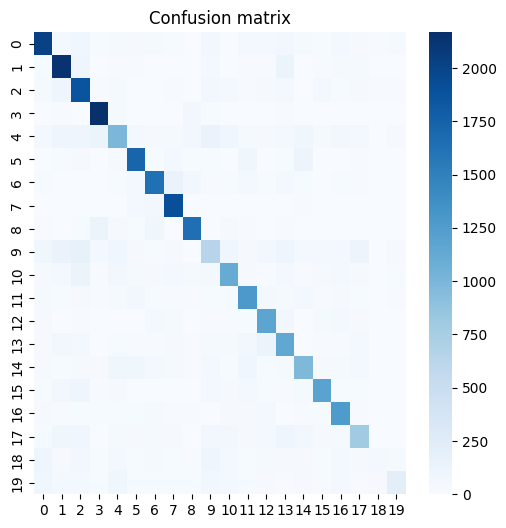

100%|██████████| 9471/9471 [01:54<00:00, 82.72it/s]


Epoch 33, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.08015
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.713   | 0.763  |  0.737   | 21738.0  |
|      1       |   0.671   | 0.818  |  0.737   | 20857.0  |
|      2       |   0.637   | 0.719  |  0.676   | 19562.0  |
|      3       |   0.806   | 0.928  |  0.862   | 18766.0  |
|      4       |   0.554   | 0.416  |  0.475   | 17651.0  |
|      5       |   0.756   | 0.775  |  0.766   | 17529.0  |
|      6       |   0.718   |  0.76  |  0.738   | 17159.0  |
|      7       |   0.757   | 0.891  |  0.818   | 16839.0  |
|      8       |   0.781   | 0.826  |  0.803   | 16131.0  |
|      9       |   0.434   | 0.346  |  0.385   | 14887.0  |
|      10      |   0.627   | 0.586  |  0.606   | 14643.0  |
|      11 

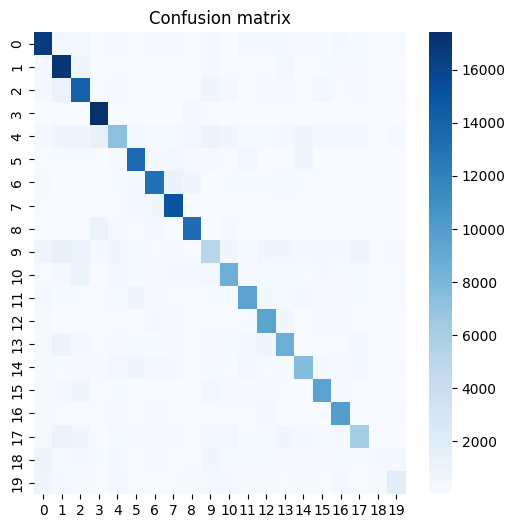

Epoch 33, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.643, Weighted=0.676] 
Balanced Accuracy = 0.649Average loss = 1.04261
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.739   | 0.767  |  0.753   | 2717.0  |
|      1       |   0.683   | 0.852  |  0.758   | 2607.0  |
|      2       |   0.672   | 0.744  |  0.707   | 2445.0  |
|      3       |   0.798   | 0.957  |   0.87   | 2346.0  |
|      4       |   0.576   |  0.46  |  0.511   | 2206.0  |
|      5       |   0.756   | 0.793  |  0.774   | 2191.0  |
|      6       |   0.706   | 0.781  |  0.742   | 2145.0  |
|      7       |   0.792   | 0.885  |  0.836   | 2105.0  |
|      8       |   0.82    | 0.803  |  0.812   | 2017.0  |
|      9       |   0.443   | 0.369  |  0.403   | 1861.0  |
|      10      |   0.674   |  0.57  |  0.618   | 1830.0  |
|      11      |   0.7

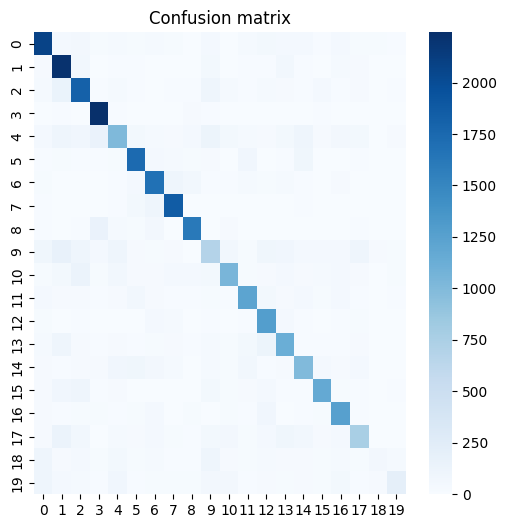

100%|██████████| 9471/9471 [01:54<00:00, 83.04it/s]


Epoch 34, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.631, Weighted=0.663] 
Balanced Accuracy = 0.638Average loss = 1.07121
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.718   | 0.766  |  0.741   | 21738.0  |
|      1       |   0.676   | 0.819  |  0.741   | 20857.0  |
|      2       |   0.633   |  0.72  |  0.674   | 19562.0  |
|      3       |   0.808   |  0.93  |  0.865   | 18766.0  |
|      4       |   0.551   | 0.416  |  0.474   | 17651.0  |
|      5       |   0.756   | 0.775  |  0.765   | 17529.0  |
|      6       |   0.718   | 0.763  |   0.74   | 17159.0  |
|      7       |   0.756   |  0.89  |  0.818   | 16839.0  |
|      8       |   0.778   | 0.827  |  0.802   | 16131.0  |
|      9       |   0.438   |  0.35  |  0.389   | 14887.0  |
|      10      |   0.629   | 0.587  |  0.607   | 14643.0  |
|      11 

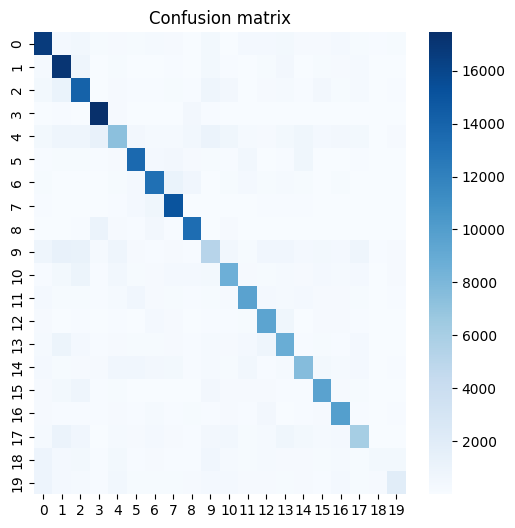

Epoch 34, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.673] 
Balanced Accuracy = 0.647Average loss = 1.03816
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.735   | 0.753  |  0.744   | 2717.0  |
|      1       |   0.708   | 0.829  |  0.764   | 2607.0  |
|      2       |   0.686   | 0.746  |  0.715   | 2445.0  |
|      3       |   0.798   | 0.949  |  0.867   | 2346.0  |
|      4       |   0.565   | 0.443  |  0.497   | 2206.0  |
|      5       |   0.756   |  0.79  |  0.773   | 2191.0  |
|      6       |   0.733   | 0.761  |  0.747   | 2145.0  |
|      7       |   0.758   | 0.928  |  0.835   | 2105.0  |
|      8       |   0.797   | 0.808  |  0.802   | 2017.0  |
|      9       |   0.448   | 0.384  |  0.414   | 1861.0  |
|      10      |   0.615   |  0.63  |  0.622   | 1830.0  |
|      11      |   0.6

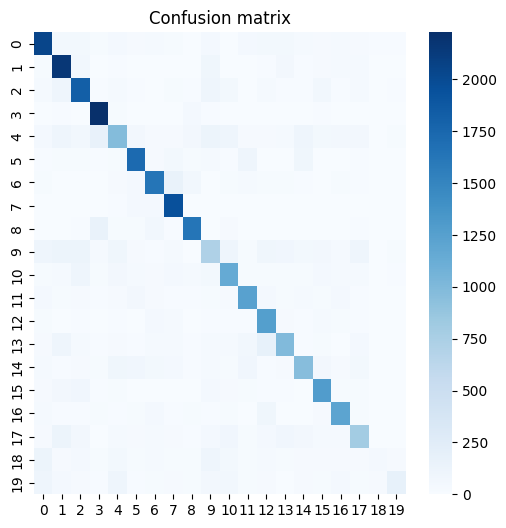

100%|██████████| 9471/9471 [01:54<00:00, 82.89it/s]


Epoch 35, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.631, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07529
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.717   | 0.763  |   0.74   | 21738.0  |
|      1       |   0.669   | 0.818  |  0.736   | 20857.0  |
|      2       |   0.637   | 0.721  |  0.676   | 19562.0  |
|      3       |   0.81    | 0.925  |  0.864   | 18766.0  |
|      4       |   0.551   |  0.42  |  0.477   | 17651.0  |
|      5       |   0.754   | 0.772  |  0.763   | 17529.0  |
|      6       |   0.723   | 0.758  |   0.74   | 17159.0  |
|      7       |   0.751   | 0.893  |  0.816   | 16839.0  |
|      8       |   0.778   | 0.825  |  0.801   | 16131.0  |
|      9       |   0.438   | 0.355  |  0.392   | 14887.0  |
|      10      |   0.623   | 0.588  |  0.605   | 14643.0  |
|      11 

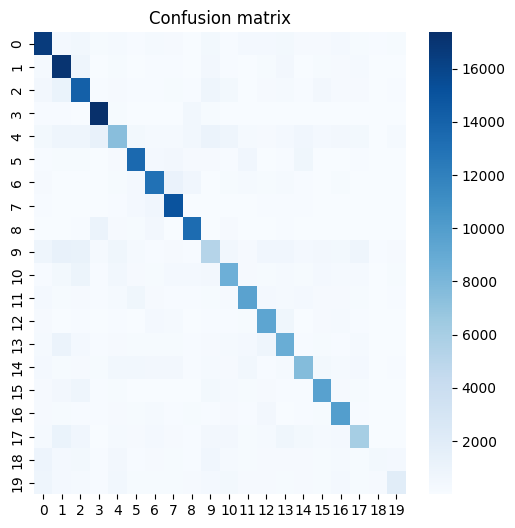

Epoch 35, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.674] 
Balanced Accuracy = 0.649Average loss = 1.04491
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.733   | 0.759  |  0.746   | 2717.0  |
|      1       |   0.678   | 0.851  |  0.755   | 2607.0  |
|      2       |   0.644   | 0.756  |  0.696   | 2445.0  |
|      3       |   0.805   | 0.946  |   0.87   | 2346.0  |
|      4       |   0.585   | 0.449  |  0.508   | 2206.0  |
|      5       |   0.754   |  0.79  |  0.771   | 2191.0  |
|      6       |   0.742   | 0.734  |  0.738   | 2145.0  |
|      7       |   0.786   | 0.901  |   0.84   | 2105.0  |
|      8       |   0.787   | 0.835  |   0.81   | 2017.0  |
|      9       |   0.454   |  0.34  |  0.389   | 1861.0  |
|      10      |   0.646   | 0.596  |   0.62   | 1830.0  |
|      11      |   0.6

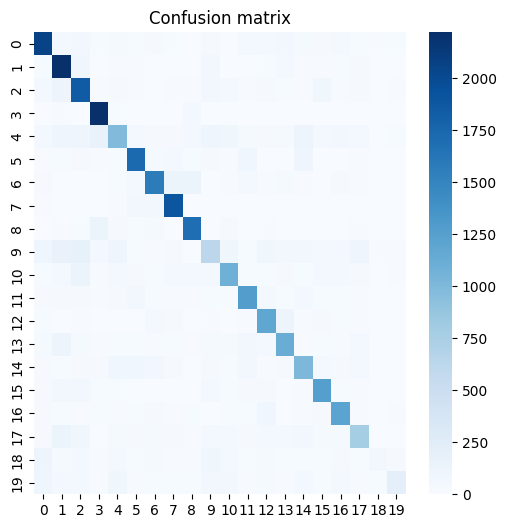

100%|██████████| 9471/9471 [01:54<00:00, 83.01it/s]


Epoch 36, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07868
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.717   | 0.761  |  0.739   | 21738.0  |
|      1       |   0.665   | 0.815  |  0.733   | 20857.0  |
|      2       |   0.63    | 0.724  |  0.674   | 19562.0  |
|      3       |   0.804   | 0.929  |  0.862   | 18766.0  |
|      4       |   0.55    | 0.419  |  0.476   | 17651.0  |
|      5       |   0.753   | 0.772  |  0.763   | 17529.0  |
|      6       |   0.718   | 0.757  |  0.737   | 17159.0  |
|      7       |   0.753   | 0.894  |  0.817   | 16839.0  |
|      8       |   0.78    | 0.823  |  0.801   | 16131.0  |
|      9       |   0.437   | 0.343  |  0.384   | 14887.0  |
|      10      |   0.635   | 0.584  |  0.608   | 14643.0  |
|      11 

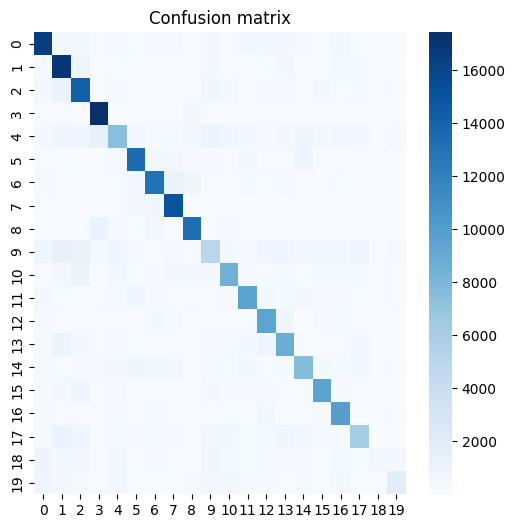

Epoch 36, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.642, Weighted=0.674] 
Balanced Accuracy = 0.647Average loss = 1.04576
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.713   | 0.767  |  0.739   | 2717.0  |
|      1       |   0.69    | 0.842  |  0.758   | 2607.0  |
|      2       |   0.642   | 0.754  |  0.694   | 2445.0  |
|      3       |   0.816   | 0.944  |  0.875   | 2346.0  |
|      4       |   0.563   |  0.46  |  0.506   | 2206.0  |
|      5       |   0.757   | 0.782  |  0.769   | 2191.0  |
|      6       |   0.723   | 0.775  |  0.748   | 2145.0  |
|      7       |   0.729   | 0.938  |   0.82   | 2105.0  |
|      8       |   0.807   |  0.81  |  0.808   | 2017.0  |
|      9       |   0.457   | 0.375  |  0.412   | 1861.0  |
|      10      |   0.668   | 0.586  |  0.624   | 1830.0  |
|      11      |   0.7

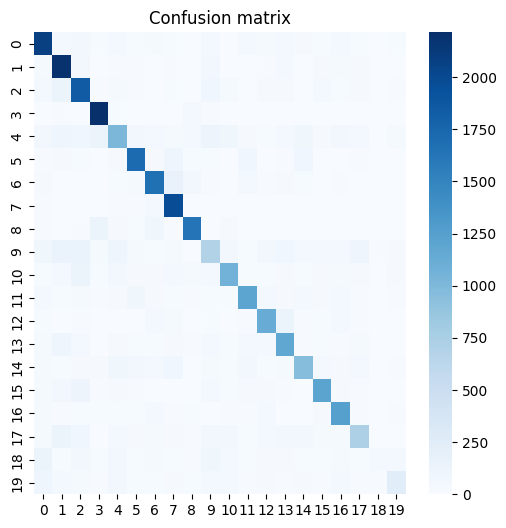

100%|██████████| 9471/9471 [01:55<00:00, 82.28it/s]


Epoch 37, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07737
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.724   | 0.765  |  0.743   | 21738.0  |
|      1       |   0.666   | 0.817  |  0.734   | 20857.0  |
|      2       |   0.637   | 0.725  |  0.678   | 19562.0  |
|      3       |   0.805   | 0.929  |  0.862   | 18766.0  |
|      4       |   0.55    | 0.414  |  0.472   | 17651.0  |
|      5       |   0.75    | 0.769  |  0.759   | 17529.0  |
|      6       |   0.718   | 0.759  |  0.738   | 17159.0  |
|      7       |   0.751   | 0.892  |  0.815   | 16839.0  |
|      8       |   0.782   | 0.821  |  0.801   | 16131.0  |
|      9       |   0.438   | 0.348  |  0.388   | 14887.0  |
|      10      |   0.632   | 0.584  |  0.607   | 14643.0  |
|      11 

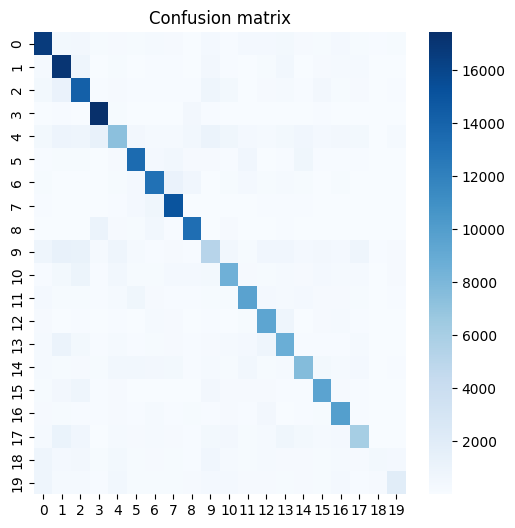

Epoch 37, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.640, Weighted=0.672] 
Balanced Accuracy = 0.646Average loss = 1.05514
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.662   | 0.798  |  0.723   | 2717.0  |
|      1       |   0.724   | 0.819  |  0.769   | 2607.0  |
|      2       |   0.628   | 0.776  |  0.694   | 2445.0  |
|      3       |   0.816   | 0.948  |  0.877   | 2346.0  |
|      4       |   0.574   | 0.439  |  0.498   | 2206.0  |
|      5       |   0.738   | 0.808  |  0.772   | 2191.0  |
|      6       |   0.73    | 0.764  |  0.746   | 2145.0  |
|      7       |   0.783   | 0.897  |  0.836   | 2105.0  |
|      8       |   0.813   |  0.79  |  0.801   | 2017.0  |
|      9       |   0.447   | 0.338  |  0.385   | 1861.0  |
|      10      |   0.668   | 0.583  |  0.622   | 1830.0  |
|      11      |   0.7

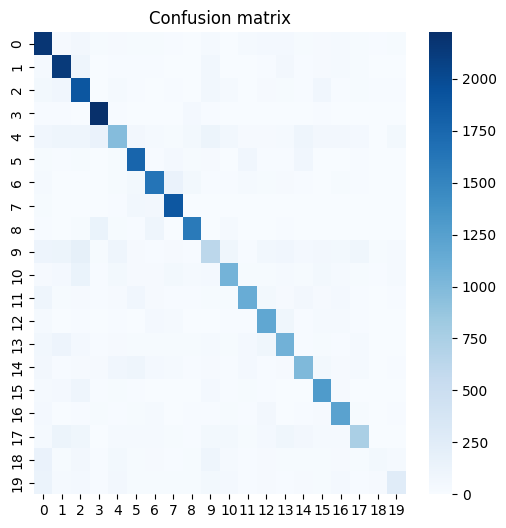

100%|██████████| 9471/9471 [01:54<00:00, 82.70it/s]


Epoch 38, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.629, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07938
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.719   | 0.764  |  0.741   | 21738.0  |
|      1       |   0.667   | 0.815  |  0.733   | 20857.0  |
|      2       |   0.63    | 0.726  |  0.675   | 19562.0  |
|      3       |   0.806   | 0.927  |  0.862   | 18766.0  |
|      4       |   0.55    | 0.417  |  0.475   | 17651.0  |
|      5       |   0.753   | 0.769  |  0.761   | 17529.0  |
|      6       |   0.717   | 0.757  |  0.737   | 17159.0  |
|      7       |   0.756   | 0.891  |  0.818   | 16839.0  |
|      8       |   0.775   | 0.821  |  0.798   | 16131.0  |
|      9       |   0.435   | 0.342  |  0.383   | 14887.0  |
|      10      |   0.632   |  0.58  |  0.605   | 14643.0  |
|      11 

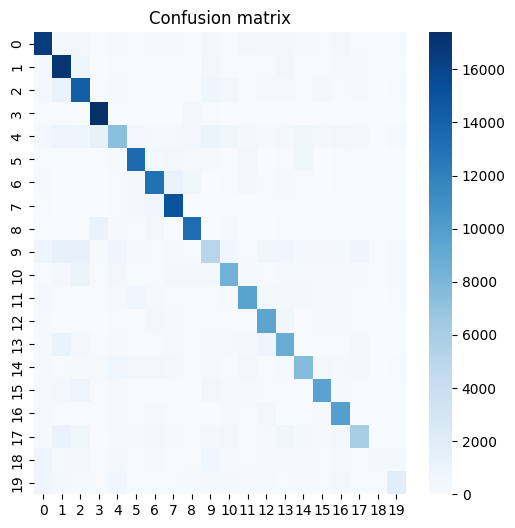

Epoch 38, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.641, Weighted=0.674] 
Balanced Accuracy = 0.648Average loss = 1.04940
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.746   | 0.755  |  0.751   | 2717.0  |
|      1       |   0.676   |  0.85  |  0.753   | 2607.0  |
|      2       |   0.669   | 0.737  |  0.701   | 2445.0  |
|      3       |   0.812   | 0.941  |  0.872   | 2346.0  |
|      4       |   0.553   |  0.44  |   0.49   | 2206.0  |
|      5       |   0.734   | 0.806  |  0.768   | 2191.0  |
|      6       |   0.705   |  0.79  |  0.745   | 2145.0  |
|      7       |   0.81    |  0.88  |  0.843   | 2105.0  |
|      8       |   0.804   | 0.787  |  0.795   | 2017.0  |
|      9       |   0.448   | 0.372  |  0.407   | 1861.0  |
|      10      |   0.659   |  0.58  |  0.617   | 1830.0  |
|      11      |   0.6

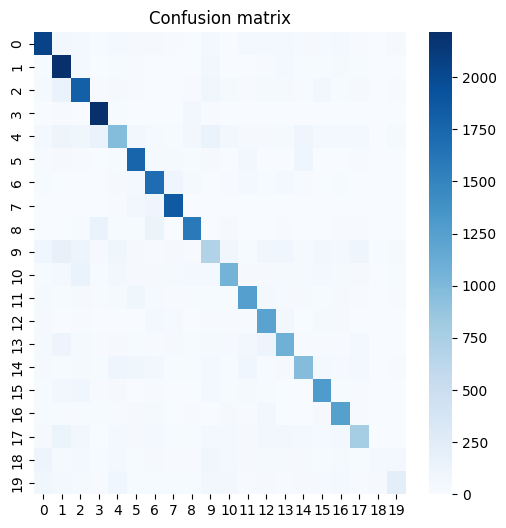

100%|██████████| 9471/9471 [01:55<00:00, 81.68it/s]


Epoch 39, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.661] 
Balanced Accuracy = 0.636Average loss = 1.07790
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   | 0.765  |  0.739   | 21738.0  |
|      1       |   0.669   | 0.814  |  0.734   | 20857.0  |
|      2       |   0.634   | 0.722  |  0.675   | 19562.0  |
|      3       |   0.807   | 0.928  |  0.863   | 18766.0  |
|      4       |   0.552   | 0.417  |  0.475   | 17651.0  |
|      5       |   0.752   | 0.772  |  0.762   | 17529.0  |
|      6       |   0.714   | 0.758  |  0.735   | 17159.0  |
|      7       |   0.758   |  0.89  |  0.819   | 16839.0  |
|      8       |   0.779   | 0.825  |  0.801   | 16131.0  |
|      9       |   0.429   |  0.34  |  0.379   | 14887.0  |
|      10      |   0.633   | 0.583  |  0.607   | 14643.0  |
|      11 

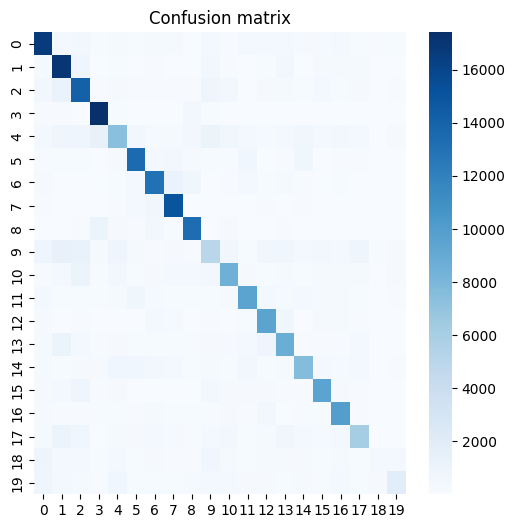

Epoch 39, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.638, Weighted=0.672] 
Balanced Accuracy = 0.647Average loss = 1.05104
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.782   | 0.715  |  0.747   | 2717.0  |
|      1       |   0.707   | 0.822  |   0.76   | 2607.0  |
|      2       |   0.68    |  0.73  |  0.704   | 2445.0  |
|      3       |   0.826   | 0.929  |  0.874   | 2346.0  |
|      4       |   0.56    | 0.455  |  0.502   | 2206.0  |
|      5       |   0.73    |  0.8   |  0.763   | 2191.0  |
|      6       |   0.774   | 0.707  |  0.739   | 2145.0  |
|      7       |   0.777   | 0.901  |  0.835   | 2105.0  |
|      8       |   0.75    | 0.865  |  0.803   | 2017.0  |
|      9       |   0.459   | 0.346  |  0.395   | 1861.0  |
|      10      |   0.629   | 0.599  |  0.614   | 1830.0  |
|      11      |   0.6

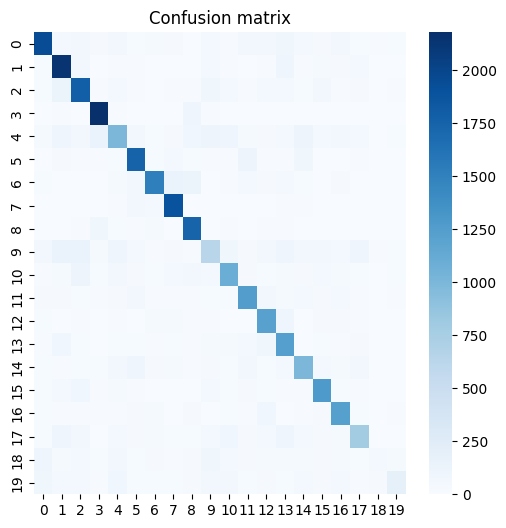

100%|██████████| 9471/9471 [01:56<00:00, 81.25it/s]


Epoch 40, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07494
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.714   | 0.766  |  0.739   | 21738.0  |
|      1       |   0.67    |  0.82  |  0.737   | 20857.0  |
|      2       |   0.636   | 0.721  |  0.676   | 19562.0  |
|      3       |   0.806   |  0.93  |  0.863   | 18766.0  |
|      4       |   0.558   | 0.412  |  0.474   | 17651.0  |
|      5       |   0.752   | 0.773  |  0.762   | 17529.0  |
|      6       |   0.721   | 0.757  |  0.738   | 17159.0  |
|      7       |   0.755   | 0.895  |  0.819   | 16839.0  |
|      8       |   0.779   | 0.824  |  0.801   | 16131.0  |
|      9       |   0.439   | 0.349  |  0.389   | 14887.0  |
|      10      |   0.629   | 0.582  |  0.605   | 14643.0  |
|      11 

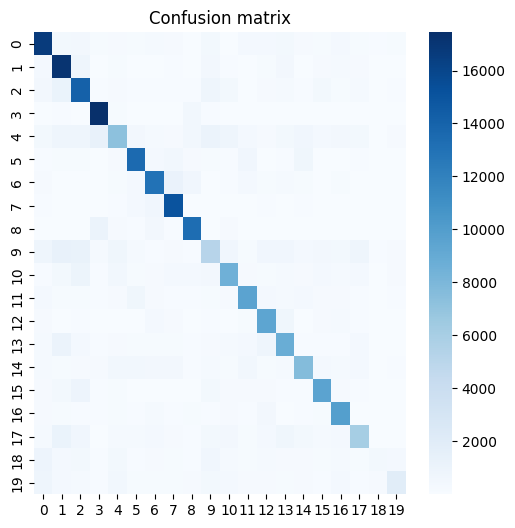

Epoch 40, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.639, Weighted=0.671] 
Balanced Accuracy = 0.646Average loss = 1.04152
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.686   | 0.784  |  0.732   | 2717.0  |
|      1       |   0.707   | 0.832  |  0.765   | 2607.0  |
|      2       |   0.662   |  0.73  |  0.695   | 2445.0  |
|      3       |   0.817   | 0.943  |  0.876   | 2346.0  |
|      4       |   0.589   | 0.426  |  0.494   | 2206.0  |
|      5       |   0.745   | 0.797  |   0.77   | 2191.0  |
|      6       |   0.721   | 0.768  |  0.744   | 2145.0  |
|      7       |   0.781   | 0.902  |  0.837   | 2105.0  |
|      8       |   0.815   | 0.806  |  0.811   | 2017.0  |
|      9       |   0.426   | 0.372  |  0.398   | 1861.0  |
|      10      |   0.676   | 0.568  |  0.618   | 1830.0  |
|      11      |   0.7

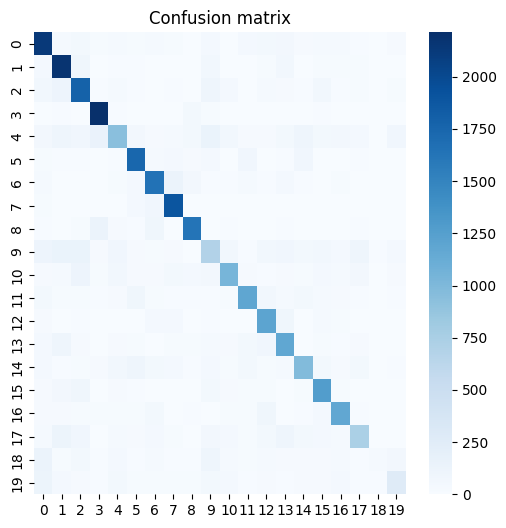

100%|██████████| 9471/9471 [01:56<00:00, 81.58it/s]


Epoch 41, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.630, Weighted=0.662] 
Balanced Accuracy = 0.637Average loss = 1.07395
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.711   | 0.765  |  0.737   | 21738.0  |
|      1       |   0.667   | 0.815  |  0.733   | 20857.0  |
|      2       |   0.633   | 0.724  |  0.676   | 19562.0  |
|      3       |   0.807   | 0.928  |  0.863   | 18766.0  |
|      4       |   0.56    | 0.417  |  0.478   | 17651.0  |
|      5       |   0.755   | 0.773  |  0.764   | 17529.0  |
|      6       |   0.718   | 0.761  |  0.739   | 17159.0  |
|      7       |   0.758   | 0.893  |   0.82   | 16839.0  |
|      8       |   0.779   | 0.825  |  0.801   | 16131.0  |
|      9       |   0.437   | 0.345  |  0.385   | 14887.0  |
|      10      |   0.634   | 0.579  |  0.605   | 14643.0  |
|      11 

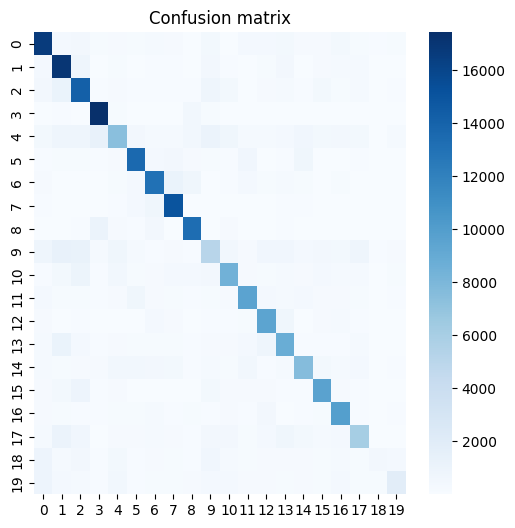

Epoch 41, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.643, Weighted=0.676] 
Balanced Accuracy = 0.649Average loss = 1.04802
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.741   | 0.758  |   0.75   | 2717.0  |
|      1       |   0.668   | 0.862  |  0.753   | 2607.0  |
|      2       |   0.685   | 0.745  |  0.714   | 2445.0  |
|      3       |   0.817   | 0.944  |  0.876   | 2346.0  |
|      4       |   0.591   | 0.419  |   0.49   | 2206.0  |
|      5       |   0.723   | 0.823  |   0.77   | 2191.0  |
|      6       |   0.73    | 0.761  |  0.745   | 2145.0  |
|      7       |   0.782   | 0.892  |  0.833   | 2105.0  |
|      8       |   0.798   | 0.828  |  0.813   | 2017.0  |
|      9       |   0.42    | 0.389  |  0.404   | 1861.0  |
|      10      |   0.616   | 0.619  |  0.617   | 1830.0  |
|      11      |   0.6

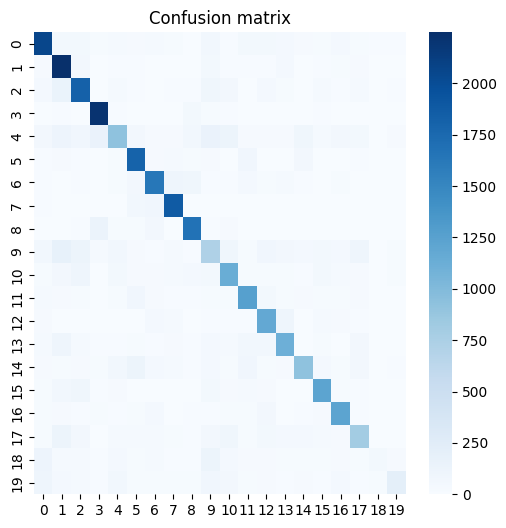

100%|██████████| 9471/9471 [01:56<00:00, 81.40it/s]


Epoch 42, training metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.632, Weighted=0.663] 
Balanced Accuracy = 0.638Average loss = 1.07395
+--------------+-----------+--------+----------+----------+
|              | precision | recall | f1-score | support  |
+--------------+-----------+--------+----------+----------+
|      0       |   0.717   | 0.761  |  0.738   | 21738.0  |
|      1       |   0.673   | 0.822  |   0.74   | 20857.0  |
|      2       |   0.637   | 0.721  |  0.677   | 19562.0  |
|      3       |   0.805   | 0.927  |  0.862   | 18766.0  |
|      4       |   0.562   | 0.416  |  0.478   | 17651.0  |
|      5       |   0.75    | 0.772  |  0.761   | 17529.0  |
|      6       |   0.719   | 0.764  |  0.741   | 17159.0  |
|      7       |   0.76    |  0.89  |   0.82   | 16839.0  |
|      8       |   0.779   | 0.824  |  0.801   | 16131.0  |
|      9       |   0.434   | 0.353  |   0.39   | 14887.0  |
|      10      |   0.638   | 0.588  |  0.612   | 14643.0  |
|      11 

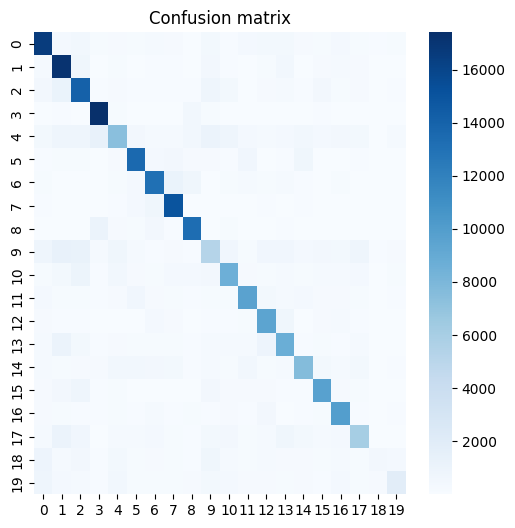

Epoch 42, validation metrics:
--- CLASSIFICATION METRICS --- 
F1 scores: [Macro=0.641, Weighted=0.675] 
Balanced Accuracy = 0.648Average loss = 1.04264
+--------------+-----------+--------+----------+---------+
|              | precision | recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|      0       |   0.659   | 0.816  |  0.729   | 2717.0  |
|      1       |   0.729   |  0.82  |  0.772   | 2607.0  |
|      2       |   0.64    | 0.775  |  0.701   | 2445.0  |
|      3       |   0.83    |  0.92  |  0.873   | 2346.0  |
|      4       |   0.576   | 0.437  |  0.497   | 2206.0  |
|      5       |   0.791   | 0.765  |  0.778   | 2191.0  |
|      6       |   0.708   | 0.778  |  0.741   | 2145.0  |
|      7       |   0.785   | 0.905  |   0.84   | 2105.0  |
|      8       |   0.774   | 0.844  |  0.808   | 2017.0  |
|      9       |   0.461   | 0.351  |  0.399   | 1861.0  |
|      10      |   0.688   | 0.558  |  0.616   | 1830.0  |
|      11      |   0.6

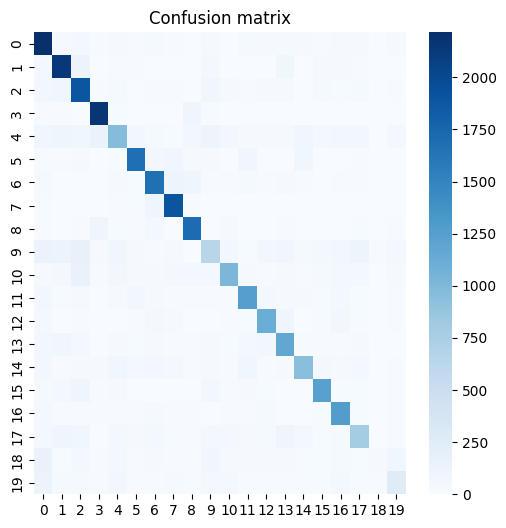

 35%|███▌      | 3340/9471 [00:41<01:11, 86.32it/s]

In [ ]:
# --- TRAINING, VALIDATION ---
train_losses, val_losses = [], []

# EARLY STOPPING
early_stop_counter = 0  # do not change
early_stop_best_loss = torch.inf
early_stop_best_model_state = None
PATIENCE = 5  # after how many epochs of no decrease in loss should we stop
DELTA = 1e-3  # if the loss decreases with maximum this delta, do not reset the counter

print(f"Beginning training... using {device} device")

for iEpoch in range(EPOCHS):
    t_loss, v_loss, (pltrain, tltrain), (plval, tlval)\
      = train_validate(train_loader=TRAIN_DATALOADER,
                       validation_loader=VALIDATION_DATALOADER,
                       model=model,
                       optimizer=optimizer,
                       scheduler=None,
                       device=device)

    print(f"Epoch {iEpoch}, training metrics:")
    calculateMetrics(t_loss, pltrain, tltrain)

    print(f"Epoch {iEpoch}, validation metrics:")
    calculateMetrics(v_loss, plval, tlval)
"""
    # -- EARLY STOPPING CHECK --
    if v_loss < early_stop_best_loss - DELTA:
        # A better loss was found, so reset counter and save model state
        early_stop_best_loss = v_loss
        early_stop_counter = 0
        # Save the best model so we can restore it later and get the best model performance to use the test data for.
        early_stop_best_model_state = model.state_dict()
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping...")

            # Restore the best model which was saved earlier.
            model.load_state_dict(early_stop_best_model_state)
            break
"""
# --- TESTING ---
avg_test_loss, (pred_labels_test, true_labels_test) = test(test_loader=TEST_DATALOADER,
                     model=model,
                     device=device)
print(f"Epoch {iEpoch}, testing metrics:")
calculateMetrics(avg_test_loss, pred_labels_test, true_labels_test)

